<a href="https://colab.research.google.com/github/Humanites-Numeriques-PSL/TP_stylo_Dumaquet/blob/main/TP1_computational_philology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Computational Philology - TP 01: Exploratory models**
Digital Humanities master's program - PSL
Florian Cafiero and Jean-Baptiste Camps

# Set up

We first start by importing the required packages. This set of packages supports text analysis and data visualization. Pandas and NumPy are used for data manipulation and numerical calculations, while matplotlib and seaborn help visualize data. NLTK and spacy are natural language processing (NLP) tools that analyze and preprocess text. Scikit-learn provides tools for machine learning, clustering, dimensionality reduction, and text vectorization. Torch eventually helps leverage GPU resources for deep learning tasks, such as POS-tagging.

In [ ]:
!pip install --upgrade scikit-learn
from google.colab import drive
import os
import glob
import importlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
import torch
from sklearn.manifold import trustworthiness
from nltk.corpus import stopwords
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
from scipy.stats import mannwhitneyu
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.preprocessing import normalize
from wordcloud import WordCloud

# Load the French language model for POS tagging

# Function to check if a model is installed (it is a mouthful, but it is useful)
def check_and_download_spacy_model(model_name='fr_core_news_sm'):
    try:
        # Try to load the model
        spacy.load(model_name)
        print(f"Model '{model_name}' is already installed.")
    except OSError:
        # If model is not found, download it
        print(f"Model '{model_name}' not found. Downloading...")
        !python -m spacy download {model_name}

# Check and download the spaCy model if necessary
check_and_download_spacy_model()

# Load the spaCy model
nlp = spacy.load('fr_core_news_sm')
print("Model loaded successfully!")

Model 'fr_core_news_sm' is already installed.
Model loaded successfully!


# A bit of caution with encoding

This is an optional yet important preprocessing step: make sure that there are not many artefacts due to various encoding, ocr etc. These various steps are examples of course, and can be selected or not for a particular text, depending on context.

In [ ]:
import unicodedata
import re

def normalize_text(text):
    """
    Normalize text by handling encodings, special characters, and spaces.
    """
    # Step 1: Convert to Unicode NFC form to normalize accents or special characters like ç
    text = unicodedata.normalize('NFC', text)

    # Step 2: Replace different types of apostrophes with a single quote
    text = re.sub(r"[’`´‘]", "'", text)

    # Step 3: Replace various quotation marks with standard double quotes
    text = re.sub(r"[“”«»„]", '"', text)

    # Step 4: Remove non-breaking spaces and replace them with regular spaces
    text = re.sub(r"\u00A0", " ", text)

    # Step 5: Remove extra spaces around punctuation
    text = re.sub(r"\s+([?.!,;:])", r"\1", text)
    text = re.sub(r"([?.!,;:])\s+", r"\1 ", text)

    # Step 6: Convert text to lowercase (if case is not significant !)
    text = text.lower()

    # Step 7: Strip leading and trailing spaces
    text = text.strip()

    return text

# Example usage
sample_text = "« Voilà un exemple génial ! » disait-il. « Qu’est-ce que tu en penses ? » Personne ne répondit, son collègue finissait encore son café."
normalized_text = normalize_text(sample_text)
print("Original:", sample_text)
print("Normalized:", normalized_text)

Original: « Voilà un exemple génial ! » disait-il. « Qu’est-ce que tu en penses ? » Personne ne répondit, son collègue finissait encore son café.
Normalized: " voilà un exemple génial! " disait-il. " qu'est-ce que tu en penses? " personne ne répondit, son collègue finissait encore son café.


# Loading the corpus

## Defining  a function to optionally normalize

In [ ]:
def load_corpus(data_path, normalize=True):
    """
    Load and optionally normalize all text files in the specified directory.

    Parameters:
    - data_path (str): Path to the directory containing text files.
    - normalize (bool): Whether to normalize the text or not.

    Returns:
    - corpus_data (list): List of text documents.
    - file_names (list): List of corresponding file names.
    """
    corpus_data = []
    file_names = []

    # Iterate over all text files in the directory
    for file_path in glob.glob(os.path.join(data_path, '*.txt')):
        try:
            with open(file_path, 'r', encoding='utf-8') as file:
                text = file.read().strip()

                # Apply normalization if the user chooses to
                if normalize:
                    text = normalize_text(text)

                if text:  # Ensure the file is not empty after optional normalization
                    corpus_data.append(text)
                    file_names.append(os.path.basename(file_path))
        except Exception as e:
            print(f"Error reading {file_path}: {e}")

    # Check if we have successfully loaded documents
    if not corpus_data:
        raise ValueError("No documents were loaded. Please check the file path and contents.")

    return corpus_data, file_names

## Loading our corpus

In [ ]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)
data_path = '/content/drive/My Drive/Dumaquet/dumaquet'
os.chdir(data_path)

# Set up device for GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

# Load corpus with optional normalization
normalize_option = True  # Set to False if you don't want normalization
corpus_data, file_names = load_corpus(data_path, normalize=normalize_option)

# Display the results
print(f"Successfully loaded {len(corpus_data)} documents with normalization set to {normalize_option}.")
print(f"Sample document: {corpus_data[0][:500]}")

NameError: name 'drive' is not defined

# Restoring balance in the corpus

First thing to do is to check whether the corpus seems homogenous enough or not, at least regarding the length of its texts.

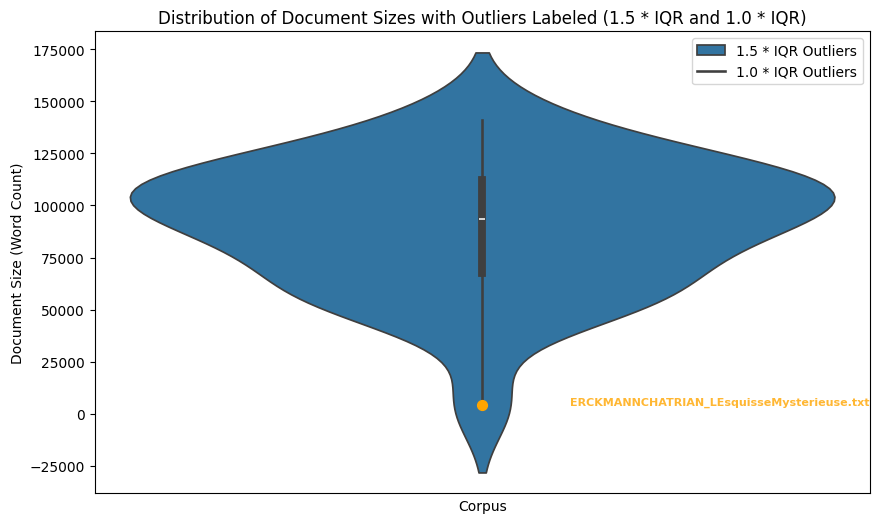

Outliers (1.5 * IQR):

Outliers (1.0 * IQR):
ERCKMANNCHATRIAN_LEsquisseMysterieuse.txt - Size: 4442


In [ ]:
# Calculate word counts for each document
word_counts = [len(doc.split()) for doc in corpus_data]
sizes_df = pd.DataFrame(word_counts, columns=["Document Size"])

# Calculate outliers based on IQR with two different thresholds
Q1 = sizes_df["Document Size"].quantile(0.25)
Q3 = sizes_df["Document Size"].quantile(0.75)
IQR = Q3 - Q1

# Define two different outlier thresholds
outlier_threshold_upper_1_5 = Q3 + 1.5 * IQR
outlier_threshold_lower_1_5 = Q1 - 1.5 * IQR

outlier_threshold_upper_1_0 = Q3 + 1.0 * IQR
outlier_threshold_lower_1_0 = Q1 - 1.0 * IQR

# Identify outliers for both thresholds
outliers_1_5 = sizes_df[(sizes_df["Document Size"] > outlier_threshold_upper_1_5) |
                        (sizes_df["Document Size"] < outlier_threshold_lower_1_5)]
outliers_1_0 = sizes_df[(sizes_df["Document Size"] > outlier_threshold_upper_1_0) |
                        (sizes_df["Document Size"] < outlier_threshold_lower_1_0)]

# Plot the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=sizes_df, y="Document Size", inner="box")

# Add outlier points with both thresholds
for idx in outliers_1_5.index:
    plt.scatter(0, word_counts[idx], color="red", s=50, zorder=3)
    plt.text(
        0.1, word_counts[idx], file_names[idx], ha="left", fontsize=8, color="red",
        weight="bold", alpha=0.8, zorder=4, label="Outlier 1.5 * IQR"
    )

for idx in outliers_1_0.index:
    plt.scatter(0, word_counts[idx], color="orange", s=50, zorder=3)
    plt.text(
        0.1, word_counts[idx], file_names[idx], ha="left", fontsize=8, color="orange",
        weight="bold", alpha=0.8, zorder=4, label="Outlier 1.0 * IQR"
    )

plt.title("Distribution of Document Sizes with Outliers Labeled (1.5 * IQR and 1.0 * IQR)")
plt.ylabel("Document Size (Word Count)")
plt.xlabel("Corpus")
plt.xticks([])
plt.legend(["1.5 * IQR Outliers", "1.0 * IQR Outliers"])
plt.show()

# Print outlier filenames and sizes for reference
print("Outliers (1.5 * IQR):")
for idx in outliers_1_5.index:
    print(f"{file_names[idx]} - Size: {word_counts[idx]}")

print("\nOutliers (1.0 * IQR):")
for idx in outliers_1_0.index:
    print(f"{file_names[idx]} - Size: {word_counts[idx]}")


## Optional removal of outliers

In [ ]:
# Choose the outlier removal option
# Option 1: Set to '1.5' for removing outliers based on 1.5 * IQR
# Option 2: Set to '1.0' for removing outliers based on 1.0 * IQR
outlier_removal_option = '1.0'  # Change to '1.0' if needed

# Define outlier indices based on the chosen option
if outlier_removal_option == '1.5':
    outlier_indices = set(outliers_1_5.index)
elif outlier_removal_option == '1.0':
    outlier_indices = set(outliers_1_0.index)
elif outlier_removal_option == 'none':
    outlier_indices = set()  # No indices to remove
else:
    raise ValueError("Invalid outlier removal option. Choose '1.5' or '1.0'.")

# Remove outliers from corpus_data and file_names based on detected indices
filtered_corpus_data = [doc for idx, doc in enumerate(corpus_data) if idx not in outlier_indices]
filtered_file_names = [name for idx, name in enumerate(file_names) if idx not in outlier_indices]

# Verify the contents after filtering
print("Number of documents after outlier removal:", len(filtered_file_names))
print("Remaining files:", filtered_file_names)


Number of documents after outlier removal: 25
Remaining files: ['DUMAS_LeCapitaineArenaT2.txt', 'DUMAS_LeCapitaineArenaT1.txt', 'DUMAS_LeCapitainePaul.txt', 'DUMASMAQUET_CollierDeLaReineT1.txt', 'DUMASMAQUET_CollierDeLaReineT2.txt', 'DUMASMAQUET_LesQuaranteCinqT1.txt', 'DUMASMAQUET_LesQuaranteCinqT2.txt', 'DUMASMAQUET_LesQuaranteCinqT3.txt', 'DUMASMAQUET_MonteCristoT1.txt', 'DUMASMAQUET_MonteCristoT2.txt', 'DUMASMAQUET_MonteCristoT3.txt', 'DUMASMAQUET_MonteCristoT4.txt', 'ERCKMANNCHATRIAN_LAmiFritz.txt', 'ERCKMANNCHATRIAN_MadameTherese.txt', 'GONCOURT_GerminieLacerteux.txt', 'GONCOURT_HistoireDeMarieAntoinette.txt', 'GONCOURT_ManetteSalomon.txt', 'MAQUET_LaBelleGabrielleT1.txt', 'MAQUET_LaBelleGabrielleT2.txt', 'MAQUET_LaBelleGabrielleT3.txt', 'SUE_MysteresParisT1.txt', 'SUE_MysteresParisT2.txt', 'SUE_MysteresParisT3.txt', 'SUE_MysteresParisT4.txt', 'SUE_MysteresParisT5.txt']


# Handling function words

One possibility would be to use a list of stopwords already provided in an NLP package such as NLTK.

In [ ]:
# Download the stopwords if not already available
nltk.download('stopwords')

# Get the French stopwords
french_stopwords = stopwords.words('french')

# Organize stopwords into a DataFrame for better readability
num_columns = 9  # Define the number of columns for display
stopwords_table = pd.DataFrame([french_stopwords[i:i + num_columns] for i in range(0, len(french_stopwords), num_columns)])
stopwords_table = stopwords_table.fillna('')  # Replace None values with empty strings
print(stopwords_table.to_string(index=False, header=False))

      au      aux    avec      ce    ces    dans      de     des     du
    elle       en      et     eux     il     ils      je      la     le
     les     leur     lui      ma   mais      me    même     mes    moi
     mon       ne     nos   notre   nous      on      ou     par    pas
    pour       qu     que     qui     sa      se     ses     son    sur
      ta       te     tes     toi    ton      tu      un     une    vos
   votre     vous       c       d      j       l       à       m      n
       s        t       y     été   étée   étées    étés   étant étante
  étants  étantes    suis      es    est  sommes    êtes    sont  serai
   seras     sera  serons   serez seront  serais  serait serions seriez
seraient    étais   était  étions  étiez étaient     fus     fut  fûmes
   fûtes   furent    sois    soit soyons   soyez  soient   fusse fusses
     fût fussions fussiez fussent  ayant  ayante ayantes  ayants     eu
     eue     eues     eus      ai     as   avons    avez     ont

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


However, the list is somehow disappointing in most treatments, and not easy to customize.

In [ ]:
# Extended list of French function words, organized by type
# (rather abitrary for now - only one nature by word for convenience, but should be better)
# (could be coupled with POS-tagging)

# Articles and determiners (except possessive determiners)
articles_determiners = [
    "le", "la", "les", "un", "une", "des", "du", "au", "aux", "ce", "cet", "cette", "ces",
    "quel", "quelle", "quels", "quelles", "chaque",
    "toute", "tous", "toutes", "quelque", "quelques", "certain", "certaine", "certains",
    "certaines", "plusieurs"
]

# Personal pronouns
personal_pronouns = [
    "je", "tu", "il", "elle", "nous", "vous", "ils", "elles", "on", "moi", "toi",
    "eux", "se", "me", "te", "lui", "leur"
]

# Possessive determiners
possessive_determiners = [
    "mon", "ma", "mes", "ton", "ta", "tes", "son", "sa", "ses",
    "notre", "votre", "nos", "vos", "leurs"
]

# Possessive pronouns
possessive_pronouns = [
    "le mien", "la mienne", "les miens", "les miennes",
    "le tien", "la tienne", "les tiens", "les tiennes",
    "le sien", "la sienne", "les siens", "les siennes",
    "le nôtre", "la nôtre", "les nôtres",
    "le vôtre", "la vôtre", "les vôtres",
    "le leur", "la leur", "les leurs"
]

# Other pronouns (demonstrative, possessive, indefinite)
other_pronouns = [
    "cela", "ça", "ceci", "celui", "celle", "ceux", "celles", "celui-ci", "celle-ci",
    "ceux-ci", "celles-ci", "celui-là", "celle-là", "ceux-là", "celles-là", "chacun", "chacune", "y"
]

# Prepositions
prepositions = [
    "à", "de", "en", "par", "pour", "dans", "sur", "sous", "chez", "avec", "entre", "contre",
    "vers", "après", "avant", "depuis", "derrière", "devant", "autour", "jusqu'", "jusqu",
    "pendant", "lors", "auprès", "dès", "dessous", "dessus"
]

# Conjunctions
conjunctions = [
    "et", "mais", "ou", "donc", "or", "ni", "car", "si", "comme", "lorsque", "puisque",
    "quoique", "bien que", "parce que", "afin que", "alors que", "tandis que", "pour que",
    "autant que", "aussi", "ainsi", "pourtant", "cependant", "toutefois", "sinon",
    "peut-être", "bien", "enfin"
]

# Adverbs
adverbs = [
    "ici", "là", "-là", "partout", "ailleurs", "toujours", "souvent", "parfois",
    "mal", "mieux", "pis", "moins", "peu", "très", "trop",
    "assez", "presque", "à peine", "beaucoup", "encore", "encor", "déjà",
    "tant", "tellement", "même", "-même"
]

# Auxiliary and modal verbs
auxiliary_verbs = [
    # Conjugations of "être"
    "être",                                                         # Infinitive
    "suis", "es", "est", "sommes", "êtes", "sont",                  # Present
    "étais", "était", "étions", "étiez", "étaient",                 # Imperfect
    "fus", "fut", "fûmes", "fûtes", "furent",                       # Simple past
    "serai", "seras", "sera", "serons", "serez", "seront",          # Future
    "serais", "serait", "serions", "seriez", "seraient",            # Conditional
    "sois", "soyons", "soyez", "soient",                            # Subjunctive present
    "fusse", "fusses", "fût", "fussions", "fussiez", "fussent",     # Subjunctive imperfect
    "étant", "été", "sois", "soyons", "soyez",                      # Participles and imperative

    # Conjugations of "avoir"
    "avoir",                                                        # Infinitive
    "ai", "as", "a", "avons", "avez", "ont",                        # Present
    "avais", "avais", "avait", "avions", "aviez", "avaient",        # Imperfect
    "eus", "eus", "eut", "eûmes", "eûtes", "eurent",                # Simple past
    "aurai", "auras", "aura", "aurons", "aurez", "auront",          # Future
    "aurais", "aurais", "aurait", "aurions", "auriez", "auraient",  # Conditional
    "aie", "aies", "ait", "ayons", "ayez", "aient",                 # Subjunctive present
    "eusse", "eusses", "eût", "eussions", "eussiez", "eussent",     # Subjunctive imperfect
    "ayant", "eu", "aie", "ayons", "ayez"                           # Participles and imperative
]

# Interrogative words
interrogative_words = [
    "qui", "que", "quoi", "où", "quand", "comment", "pourquoi", "combien", "lequel", "laquelle",
    "lesquels", "lesquelles"
]

# Negations
negations = [
    "ne", "n'", "n" "pas", "plus", "jamais", "rien", "personne", "aucun", "aucune", "nulle", "sans"
]

# Collect the type of function words you want to work on into one list (here is an example setting, but you can play with it)
function_words = list(set(
    articles_determiners + other_pronouns + prepositions +
    conjunctions + adverbs + auxiliary_verbs + interrogative_words + negations
))

print("Number of function words:", len(function_words))

Number of function words: 232


Both approaches present a problem: some words are of ambiguous nature. In French e.g., "or" can mean "yet" or "now", but can also mean "gold" if it is a noun. POS tagging can thus be very useful. But be careful, it takes a while ! We need to POS-tag the corpus as a whole, then filter accordingly.

**The Mr Obvious moment**: POS-tagging needs context, if you run it on the words that only interest you, it will be quicker, yet completely useless ("thank you, Mr Obvious!")

In [ ]:
# Define POS tags associated with function words
function_pos_tags = {
    'DET',    # Determiners
    'PRON',   # Pronouns
    'ADP',    # Prepositions
    'CCONJ',  # Coordinating conjunctions
    'SCONJ',  # Subordinating conjunctions
    'AUX',    # Auxiliary verbs
    'ADV',    # Adverbs
    'PART'    # Particles
}

# Helper function to filter function words
def filter_function_words(text, function_pos_tags, function_words):
    # Tag the entire text using spacy for accurate context-based POS tagging
    doc = nlp(text)
    # Filter words based on their POS tags and inclusion in the function words list
    filtered_words = [
        token.text for token in doc
        if token.pos_ in function_pos_tags and token.text in function_words
    ]
    return ' '.join(filtered_words)

# New variable to store the corpus after function word filtering
function_words_corpus_data = []

# Iterate through each document in the filtered corpus
for text in filtered_corpus_data:
    filtered_text = filter_function_words(text, function_pos_tags, function_words)
    function_words_corpus_data.append(filtered_text)

# Display the number of function words for verification
print("Filtered corpus data (only function words):", function_words_corpus_data)


Filtered corpus data (only function words): ["le en à le au quoique le fût à et que par n' eût rien à à cette au que en à de la et au quelque à le qui la que chacun pour à la à peu pendant ce les de étaient entre et un qui assez était de de et ne à ces au de ces le et à que toujours à si la est que le que le et que le pour du est en est bien qui était de avec si le a est a a la était bien y quelque sous la toute n' est les un de qui que comme chacun avait la du est que lorsque ce de le plus moins ne du est quelle le le derrière quelle le jusqu' au plus du de ce sera pour ce entre et un après que le sera sera entre et le avec la même que si eût été ou qui eût la en ce au ne de en et que à le est ce que le le bien donc le chacun à en un et sans une le fut à la fut et le vers le de sous de aux n' y un de ne cependant était que quoique sans à était à en mais comme cette de bien aussi du que chacun de de ou de n' y et que cette à vers les qui peu à peu et en cette étaient des de à un de à p

## Applying normalizations

smooth_idf= :

This parameter ensures that IDF scores are smoothed by adding 1 to the document frequency (DF) of each term. This prevents division by zero for terms that may appear in only one document. Smoothing is generally recommended to avoid overly high weights for rare terms.

sublinear_tf= :

Sublinear Term Frequency Scaling: This parameter applies logarithmic scaling to the Term Frequency (TF) component. This prevents very common terms from being overly dominant just because they appear frequently in a single document.
If sublinear_tf=False, it uses raw term counts without any scaling.

In [ ]:
# Create the CountVectorizer
vectorizer = CountVectorizer()

# Create Document-Term Matrix using the function words filtered corpus
dtm = vectorizer.fit_transform(function_words_corpus_data)

# Apply TF-IDF normalization
tfidf_transformer = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)
dtm_tfidf = tfidf_transformer.fit_transform(dtm)
dtm_matrix = dtm_tfidf.toarray()

# Inspect DTM shape and contents
print("Document-Term Matrix shape:", dtm_matrix.shape)
print("Feature names (function words):", vectorizer.get_feature_names_out())
print("Sample normalized TF-IDF values:\n", dtm_matrix[:5])  # Display the first few rows of the matrix for verification


Document-Term Matrix shape: (25, 193)
Feature names (function words): ['ai' 'aie' 'aient' 'ailleurs' 'ainsi' 'ait' 'après' 'as' 'assez' 'au'
 'aucun' 'aucune' 'auprès' 'aura' 'aurai' 'auraient' 'aurais' 'aurait'
 'aurez' 'auriez' 'aurions' 'aurons' 'auront' 'aussi' 'autour' 'aux'
 'avaient' 'avais' 'avait' 'avant' 'avec' 'avez' 'aviez' 'avions' 'avoir'
 'avons' 'ayant' 'ayez' 'ayons' 'beaucoup' 'bien' 'car' 'ce' 'ceci' 'cela'
 'celle' 'celles' 'celui' 'cependant' 'certaines' 'certains' 'ces' 'cet'
 'cette' 'ceux' 'chacun' 'chacune' 'chaque' 'chez' 'ci' 'combien' 'comme'
 'comment' 'contre' 'dans' 'de' 'depuis' 'derrière' 'des' 'dessous'
 'dessus' 'devant' 'donc' 'du' 'dès' 'déjà' 'en' 'encore' 'enfin' 'entre'
 'es' 'est' 'et' 'eurent' 'eus' 'eussent' 'eussiez' 'eussions' 'eut' 'eût'
 'eûtes' 'furent' 'fus' 'fussent' 'fussiez' 'fut' 'fûmes' 'fût' 'ici'
 'jamais' 'jusqu' 'la' 'laquelle' 'le' 'lequel' 'les' 'lesquelles'
 'lesquels' 'lors' 'lorsque' 'là' 'mais' 'mal' 'mieux' 'moins' 'même'

# Dimension reduction

## Principal Component Analysis

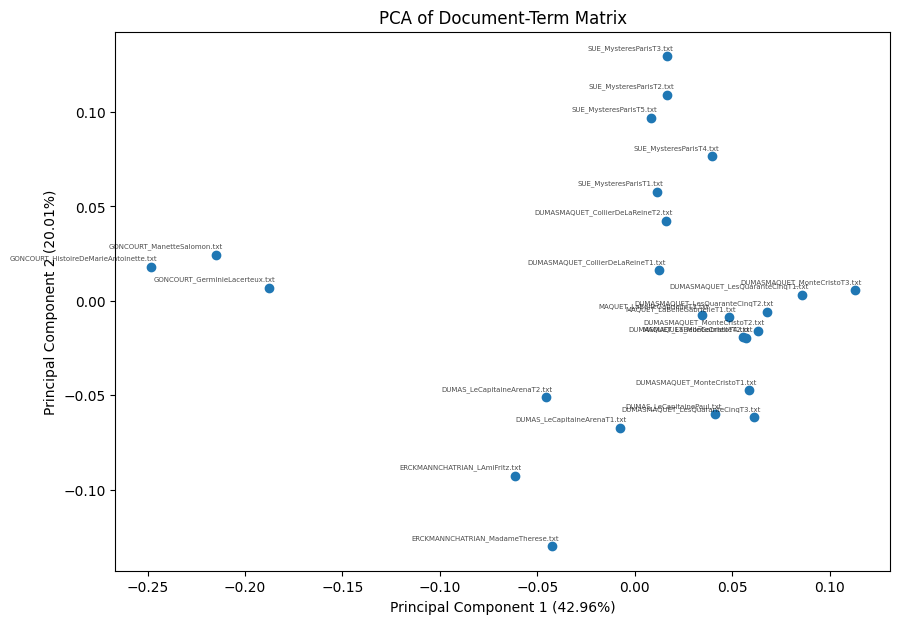

In [ ]:
# Perform PCA on the DTM
pca = PCA(n_components=2)
pca_result = pca.fit_transform(dtm_matrix)

# Calculate the percentage of variance explained by each component
explained_variance = pca.explained_variance_ratio_ * 100  # Convert to percentage

# Plot PCA result with labels and explained variance
plt.figure(figsize=(10, 7))
plt.scatter(pca_result[:, 0], pca_result[:, 1])

# Adding the explained variance to axis labels
plt.xlabel(f"Principal Component 1 ({explained_variance[0]:.2f}%)")
plt.ylabel(f"Principal Component 2 ({explained_variance[1]:.2f}%)")
plt.title("PCA of Document-Term Matrix")

# Add file names as labels for each point
for i, filename in enumerate(filtered_file_names):
    plt.annotate(
        filename,
        (pca_result[i, 0], pca_result[i, 1]),
        textcoords="offset points",
        xytext=(5, 5),  # Offset label to avoid overlap with the point
        ha="right",
        fontsize=5,     # Adjust font size for readability
        alpha=0.7       # Slight transparency for better readability - set up according to your preferences
    )

plt.show()


If we used a naming following the stylo package convention (in R), we can use this scrit to display differently each texts according to their (alleged) author.

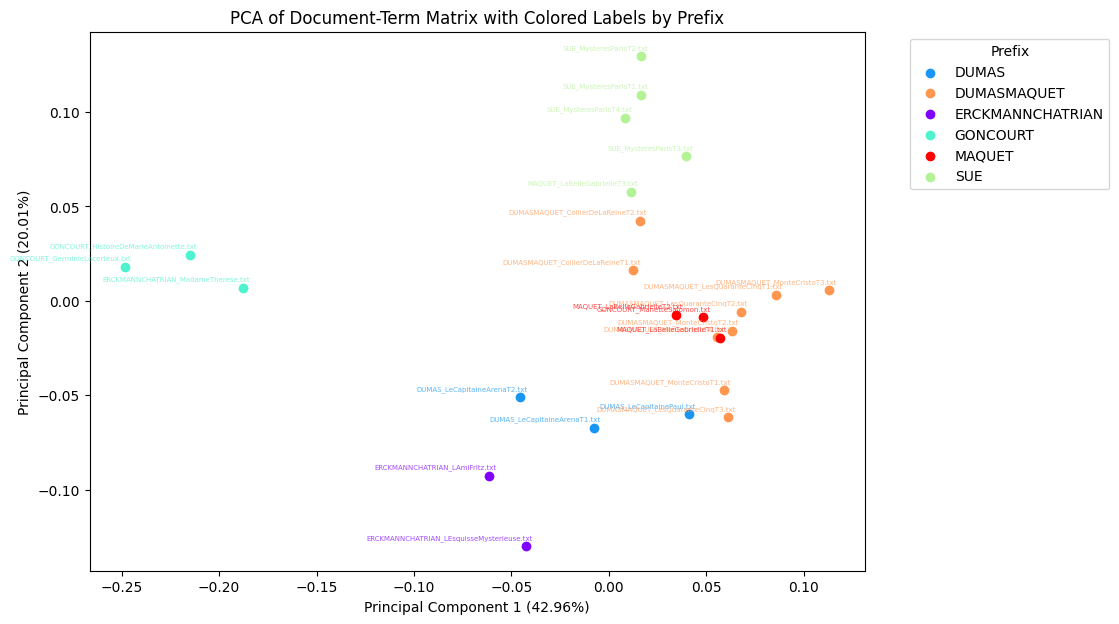

In [ ]:
# Extract prefixes from filtered filenames
prefixes = [filename.split("_")[0] for filename in filtered_file_names]


# Get unique prefixes and assign each a unique color
unique_prefixes = list(set(prefixes))
colors = cm.rainbow(np.linspace(0, 1, len(unique_prefixes)))  # Generate colors from a colormap
color_map = {prefix: color for prefix, color in zip(unique_prefixes, colors)}

# Plot PCA result with colored labels based on prefix
plt.figure(figsize=(10, 7))
for i, (x, y) in enumerate(pca_result):
    prefix = prefixes[i]
    plt.scatter(x, y, color=color_map[prefix], label=prefix if i == prefixes.index(prefix) else "")  # Show label in legend once
    plt.annotate(
        file_names[i],
        (x, y),
        textcoords="offset points",
        xytext=(5, 5),  # Offset label to avoid overlap with the point
        ha="right",
        fontsize=5,     # Adjust font size for readability
        alpha=0.7,      # Slight transparency for better readability
        color=color_map[prefix]  # Color based on prefix
    )

# Adding the explained variance to axis labels
plt.xlabel(f"Principal Component 1 ({explained_variance[0]:.2f}%)")
plt.ylabel(f"Principal Component 2 ({explained_variance[1]:.2f}%)")
plt.title("PCA of Document-Term Matrix with Colored Labels by Prefix")

# Create a legend to show which color corresponds to which prefix
plt.legend(title="Prefix", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


## Analyzing contributions

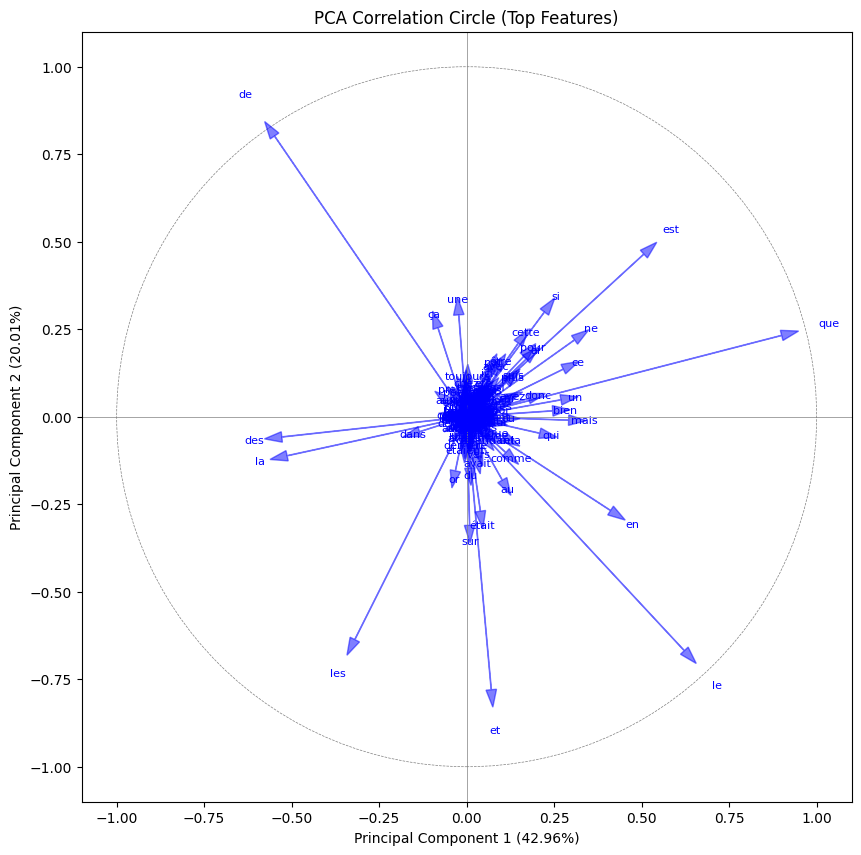

In [ ]:
# Define feature names if not already defined
feature_names = vectorizer.get_feature_names_out()

# Define loadings from the PCA model
loadings = pca.components_  # Loadings represent the contribution of each feature

# Calculate a scaling factor based on the maximum arrow length
max_loading = np.max(np.abs(loadings[:2]))  # Get the max loading for the first two components
scaling_factor = 0.9 / max_loading  # Scale arrows to fit within the unit circle


plt.figure(figsize=(10, 10))
plt.axhline(0, color='grey', lw=0.5)
plt.axvline(0, color='grey', lw=0.5)

# Plot the unit circle
circle = plt.Circle((0, 0), 1, color='grey', fill=False, linestyle='--', linewidth=0.5)
plt.gca().add_artist(circle)

# Plot each feature as an arrow, scaled to fit within the circle
for i in range(len(feature_names)):
    plt.arrow(0, 0,
              loadings[0, i] * scaling_factor,
              loadings[1, i] * scaling_factor,
              color='b', alpha=0.5, head_width=0.03, head_length=0.05)
    plt.text(loadings[0, i] * scaling_factor * 1.15,
             loadings[1, i] * scaling_factor * 1.15,
             feature_names[i],
             color='blue', ha='center', va='center', fontsize=8)

# Configure plot aesthetics
plt.xlabel(f"Principal Component 1 ({explained_variance[0]:.2f}%)")
plt.ylabel(f"Principal Component 2 ({explained_variance[1]:.2f}%)")
plt.title("PCA Correlation Circle (Top Features)")
plt.grid(False)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()



## Filtering authors

6 authors is too much... Let's deal with it, by using a good number of authors, and passing the text to attribute as supplementary.

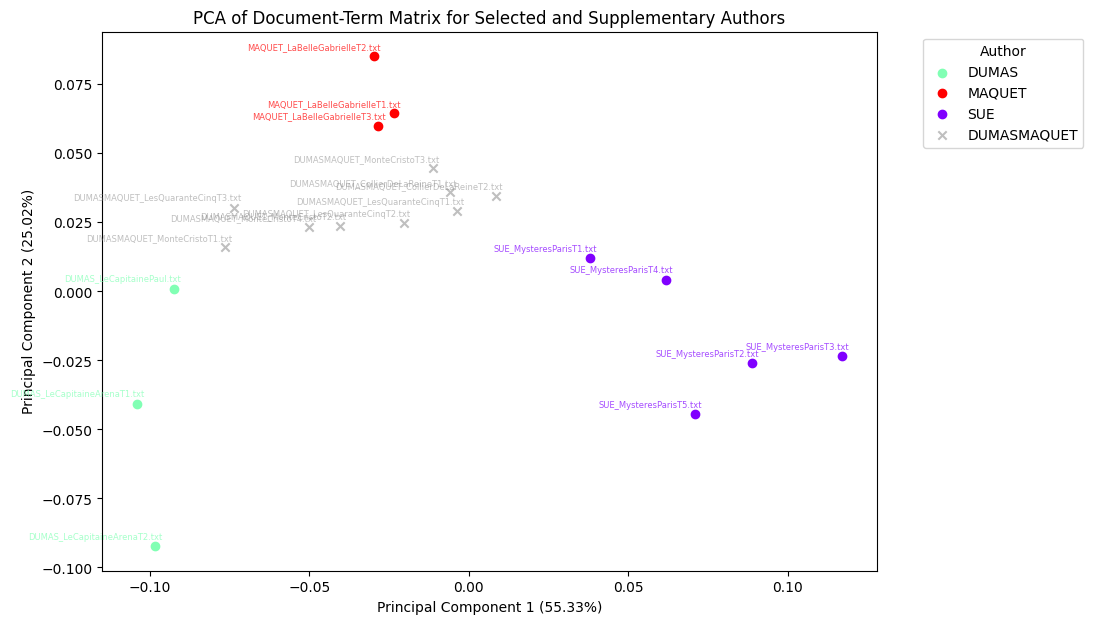

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

def pca_by_authors(selected_authors, supplementary_authors, filtered_file_names, data_matrix, explained_variance):
    """
    Filters the data matrix to display PCA results for specified main authors
    and projects supplementary authors onto the precomputed PCA space.

    Parameters:
    - selected_authors (list of str): List of main authors to include in PCA computation.
    - supplementary_authors (list of str): List of supplementary authors to project onto PCA.
    - filtered_file_names (list of str): List of all filenames.
    - data_matrix (ndarray): The original data matrix (e.g., TF-IDF matrix).
    - explained_variance (list or ndarray): Percentage of variance explained by each PCA component.
    """
    # Step 1: Filter filenames and data matrix for selected main authors
    selected_indices = [i for i, filename in enumerate(filtered_file_names)
                        if filename.split("_")[0] in selected_authors]
    supplementary_indices = [i for i, filename in enumerate(filtered_file_names)
                             if filename.split("_")[0] in supplementary_authors]

    # Separate data matrix for main authors and supplementary authors
    selected_data = data_matrix[selected_indices]
    supplementary_data = data_matrix[supplementary_indices]

    selected_file_names = [filtered_file_names[i] for i in selected_indices]
    supplementary_file_names = [filtered_file_names[i] for i in supplementary_indices]

    selected_prefixes = [filename.split("_")[0] for filename in selected_file_names]
    supplementary_prefixes = [filename.split("_")[0] for filename in supplementary_file_names]

    # Step 2: Perform PCA on the data of the selected authors
    pca = PCA(n_components=2)
    selected_pca_result = pca.fit_transform(selected_data)

    # Step 3: Project the supplementary authors' data onto the precomputed PCA space
    supplementary_pca_result = pca.transform(supplementary_data)

    # Step 4: Generate unique colors for each main author
    unique_authors = list(set(selected_prefixes))
    colors = cm.rainbow(np.linspace(0, 1, len(unique_authors)))
    color_map = {author: color for author, color in zip(unique_authors, colors)}

    # Step 5: Plot the PCA result for the selected authors
    plt.figure(figsize=(10, 7))
    for i, (x, y) in enumerate(selected_pca_result):
        author_prefix = selected_prefixes[i]
        plt.scatter(x, y, color=color_map[author_prefix],
                    label=author_prefix if i == selected_prefixes.index(author_prefix) else "")
        plt.annotate(
            selected_file_names[i],
            (x, y),
            textcoords="offset points",
            xytext=(5, 5),
            ha="right",
            fontsize=6,
            alpha=0.7,
            color=color_map[author_prefix]
        )

    # Step 6: Plot the supplementary authors with a different marker or transparency
    for i, (x, y) in enumerate(supplementary_pca_result):
        author_prefix = supplementary_prefixes[i]
        plt.scatter(x, y, color='gray', marker='x', alpha=0.5,
                    label=author_prefix if i == supplementary_prefixes.index(author_prefix) else "")
        plt.annotate(
            supplementary_file_names[i],
            (x, y),
            textcoords="offset points",
            xytext=(5, 5),
            ha="right",
            fontsize=6,
            alpha=0.5,
            color='gray'
        )

    # Step 7: Adding explained variance to axis labels
    plt.xlabel(f"Principal Component 1 ({pca.explained_variance_ratio_[0] * 100:.2f}%)")
    plt.ylabel(f"Principal Component 2 ({pca.explained_variance_ratio_[1] * 100:.2f}%)")
    plt.title("PCA of Document-Term Matrix for Selected and Supplementary Authors")

    # Step 8: Create a legend to show which color corresponds to which main author
    plt.legend(title="Author", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Example usage:
pca_by_authors(
    selected_authors=["DUMAS", "MAQUET", "SUE"],
    supplementary_authors=["DUMASMAQUET"],
    filtered_file_names=filtered_file_names,
    data_matrix=dtm_matrix,
    explained_variance=explained_variance
)


## T-SNE

## Regular use (without supposing the prefixing 'à la stylo'

Number of documents (samples): 25


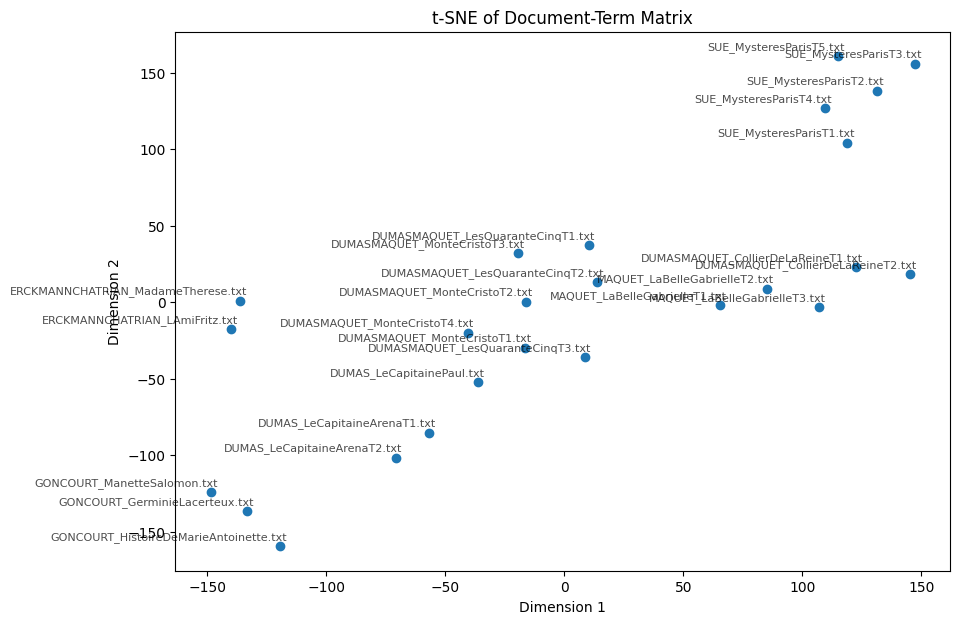

In [ ]:
# Check the number of samples
num_samples = dtm_matrix.shape[0]
print(f"Number of documents (samples): {num_samples}")

# Set perplexity to a smaller value, such as min(5, num_samples - 1) if fewer than 5 samples are present - it will avoid some errors (add messages to handle this better maybe ?)
adjusted_perplexity = 6

## t-SNE with adjusted perplexity
tsne = TSNE(n_components=2, perplexity=adjusted_perplexity, max_iter=1000)
tsne_result = tsne.fit_transform(dtm_matrix)

# Plot t-SNE result with file names as labels
plt.figure(figsize=(10, 7))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1])

plt.title("t-SNE of Document-Term Matrix")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

# Add file names as labels for each point
for i, filename in enumerate(filtered_file_names):
    plt.annotate(
        filename,
        (tsne_result[i, 0], tsne_result[i, 1]),
        textcoords="offset points",
        xytext=(5, 5),  # Offset to avoid overlap with the point
        ha="right",
        fontsize=8,     # Adjust font size for readability
        alpha=0.7       # Slight transparency for better readability
    )

plt.show()


## Coloring by label

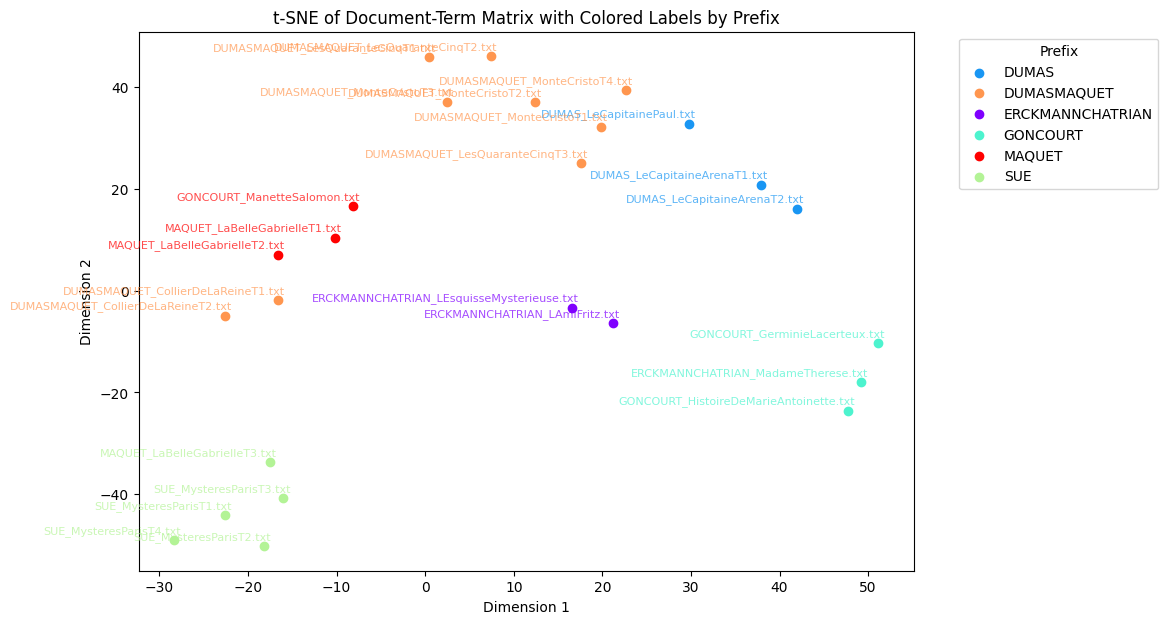

In [ ]:
# Extract prefixes from filenames
prefixes = [filename.split("_")[0] for filename in filtered_file_names]

# Get unique prefixes and assign each a unique color
unique_prefixes = list(set(prefixes))
colors = cm.rainbow(np.linspace(0, 1, len(unique_prefixes)))  # Generate colors from a colormap
color_map = {prefix: color for prefix, color in zip(unique_prefixes, colors)}

# Plot t-SNE result with colored labels based on prefix
plt.figure(figsize=(10, 7))
for i, (x, y) in enumerate(tsne_result):
    prefix = prefixes[i]
    plt.scatter(x, y, color=color_map[prefix], label=prefix if i == prefixes.index(prefix) else "")  # Show label in legend once
    plt.annotate(
        file_names[i],
        (x, y),
        textcoords="offset points",
        xytext=(5, 5),  # Offset label to avoid overlap with the point
        ha="right",
        fontsize=8,     # Adjust font size for readability
        alpha=0.7,      # Slight transparency for better readability
        color=color_map[prefix]  # Color based on prefix
    )

# Add plot title and labels
plt.title("t-SNE of Document-Term Matrix with Colored Labels by Prefix")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

# Create a legend to show which color corresponds to which prefix
plt.legend(title="Prefix", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


## Interpretation of the t-SNE

t-SNE is a non-linear dimensionality reduction technique, and it does not directly provide feature importance scores like linear models or tree-based algorithms do. A shortcut can be the following:  by correlating the original features (our chosen terms or features in the DTM) with the resulting t-SNE dimensions, we can get an idea of which features influence the positions of the points in the 2D space.


Top 10 positive features correlated with t-SNE Dimension 1:
avait      0.467428
avaient    0.494855
les        0.502672
et         0.520327
autour     0.527259
sur        0.528041
dans       0.530534
étaient    0.546891
était      0.550089
des        0.568911
Name: TSNE_1, dtype: float64

Top 10 negative features correlated with t-SNE Dimension 1:
ici     -0.883877
ne      -0.854359
est     -0.851156
pour    -0.834075
être    -0.824832
ci      -0.824002
ainsi   -0.817278
ai      -0.799264
peut    -0.796623
si      -0.796218
Name: TSNE_1, dtype: float64

Top 10 positive features correlated with t-SNE Dimension 2:
eut          0.611326
fût          0.615614
laquelle     0.639860
toutefois    0.648377
vers         0.660889
le           0.697349
quelque      0.724988
même         0.783270
lequel       0.797122
cependant    0.913224
Name: TSNE_2, dtype: float64

Top 10 negative features correlated with t-SNE Dimension 2:
pourtant   -0.838685
auprès     -0.790065
ça         -0.765124
souven

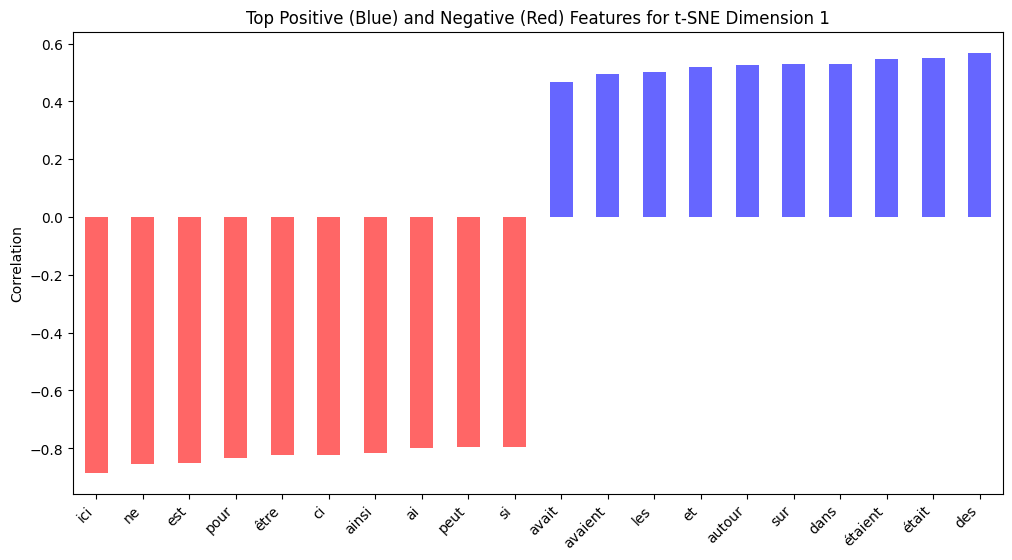

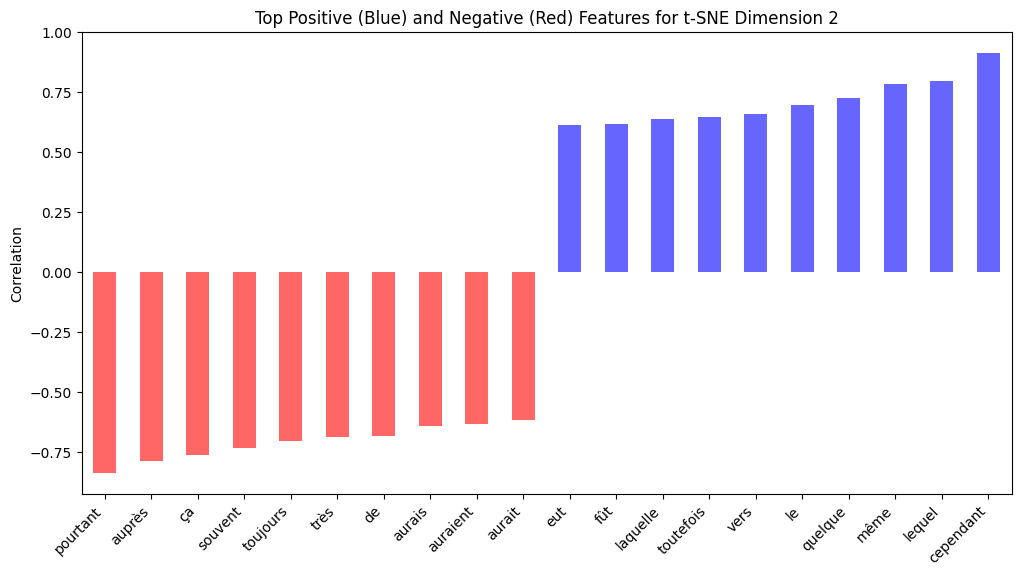

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Ensure dtm_matrix is a DataFrame with correct feature names
if not isinstance(dtm_matrix, pd.DataFrame):
    feature_names = vectorizer.get_feature_names_out()  # Replace 'vectorizer' with your actual vectorizer instance
    dtm_df = pd.DataFrame(dtm_matrix, columns=feature_names)
else:
    dtm_df = dtm_matrix  # It's already a DataFrame with columns

# Create a DataFrame from the t-SNE results
tsne_df = pd.DataFrame(tsne_result, columns=['TSNE_1', 'TSNE_2'])

# Concatenate the DTM features with the t-SNE results
merged_df = pd.concat([dtm_df, tsne_df], axis=1)

# Compute correlation between DTM features and t-SNE components
correlation_matrix = merged_df.corr()

# Extract correlations of each feature with the t-SNE dimensions
tsne_feature_correlation = correlation_matrix[['TSNE_1', 'TSNE_2']].drop(['TSNE_1', 'TSNE_2'])

# Function to get top 10 positive and top 10 negative features for each dimension
def get_top_positive_negative(correlations, dimension):
    # Sort correlations for the specified dimension
    sorted_corr = correlations[dimension].sort_values()
    # Get top 10 negative and top 10 positive correlations
    top_negative = sorted_corr.head(10)
    top_positive = sorted_corr.tail(10)
    return top_positive, top_negative

# Get top positive and negative features for t-SNE Dimension 1
top_positive_tsne1, top_negative_tsne1 = get_top_positive_negative(tsne_feature_correlation, 'TSNE_1')

# Get top positive and negative features for t-SNE Dimension 2
top_positive_tsne2, top_negative_tsne2 = get_top_positive_negative(tsne_feature_correlation, 'TSNE_2')

# Print results
print("\nTop 10 positive features correlated with t-SNE Dimension 1:")
print(top_positive_tsne1)

print("\nTop 10 negative features correlated with t-SNE Dimension 1:")
print(top_negative_tsne1)

print("\nTop 10 positive features correlated with t-SNE Dimension 2:")
print(top_positive_tsne2)

print("\nTop 10 negative features correlated with t-SNE Dimension 2:")
print(top_negative_tsne2)

# Plot the top positive and negative correlated features
def plot_top_features(top_positive, top_negative, dimension):
    plt.figure(figsize=(12, 6))
    top_features = pd.concat([top_negative, top_positive])
    colors = ['red'] * len(top_negative) + ['blue'] * len(top_positive)
    top_features.plot(kind='bar', color=colors, alpha=0.6)
    plt.title(f"Top Positive (Blue) and Negative (Red) Features for {dimension}")
    plt.ylabel("Correlation")
    plt.xticks(rotation=45, ha='right')
    plt.show()

# Plot for t-SNE Dimension 1
plot_top_features(top_positive_tsne1, top_negative_tsne1, 't-SNE Dimension 1')

# Plot for t-SNE Dimension 2
plot_top_features(top_positive_tsne2, top_negative_tsne2, 't-SNE Dimension 2')



## Multi dimensional scaling

### Metric MDS

Stress du MDS : 0.0037
Très bon ajustement (le MDS préserve bien les distances).


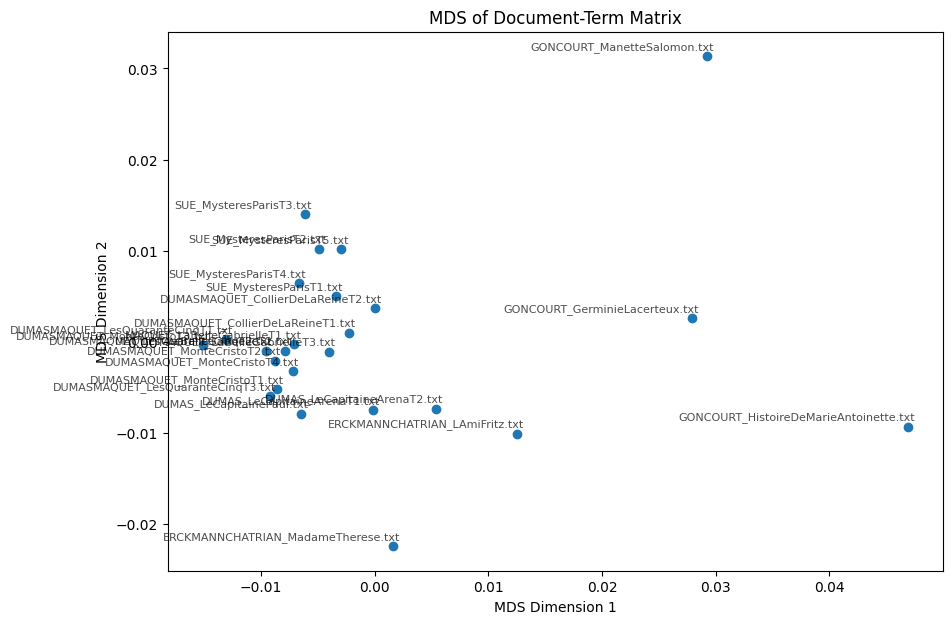

In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# Calculer la matrice des distances (ici avec la distance cosinus)
distance_matrix = pdist(dtm_matrix, 'cosine')

# Effectuer le MDS avec la matrice de distances pré-calculée
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
mds_result = mds.fit_transform(squareform(distance_matrix))

# Calculer le stress
stress = mds.stress_

# Afficher le stress avec une interprétation
print(f"Stress du MDS : {stress:.4f}")
if stress < 0.05:
    print("Très bon ajustement (le MDS préserve bien les distances).")
elif stress < 0.1:
    print("Bon ajustement (le MDS préserve assez bien les distances).")
elif stress < 0.2:
    print("Ajustement moyen (quelques distorsions dans la préservation des distances).")
else:
    print("Ajustement faible (le MDS ne préserve pas bien les distances).")

# Visualiser le résultat du MDS
plt.figure(figsize=(10, 7))
plt.scatter(mds_result[:, 0], mds_result[:, 1])

plt.title("MDS of Document-Term Matrix")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")

# Ajouter les noms des fichiers comme labels pour chaque point
for i, filename in enumerate(filtered_file_names):
    plt.annotate(
        filename,
        (mds_result[i, 0], mds_result[i, 1]),
        textcoords="offset points",
        xytext=(5, 5),  # Décalage du label pour éviter le chevauchement
        ha="right",
        fontsize=8,
        alpha=0.7
    )

plt.show()


#### Coloring by label

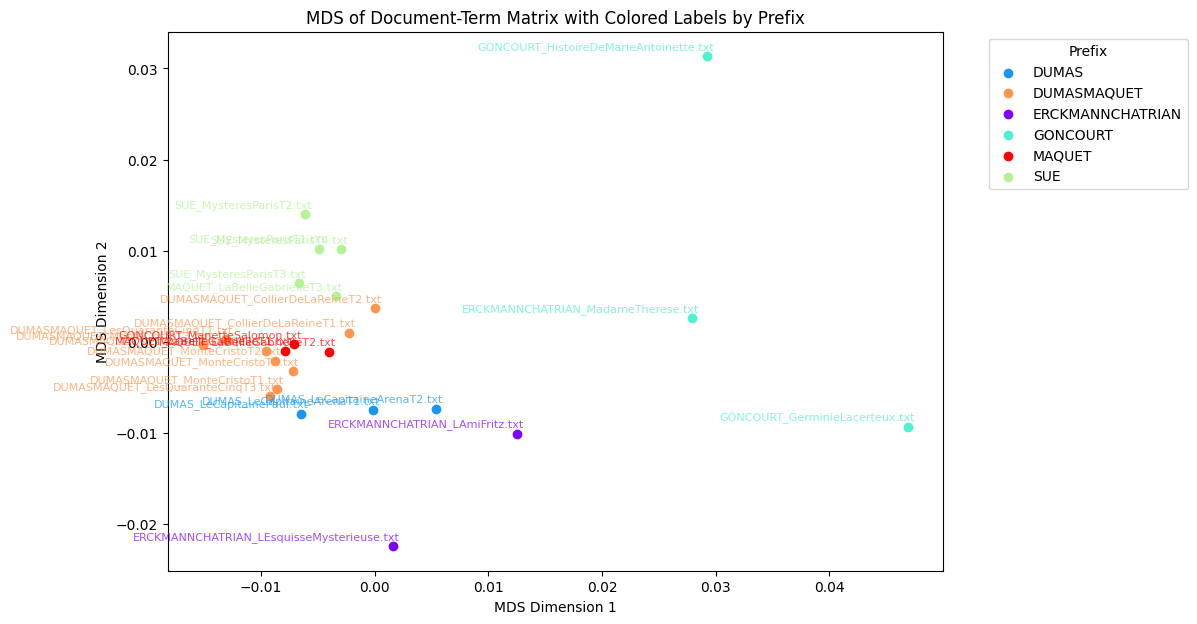

In [ ]:
# Extract prefixes from filenames, ensuring alignment with mds_result
prefixes = [filename.split("_")[0] for filename in filtered_file_names]  # Use file_names instead of filtered_file_names

# Get unique prefixes and assign each a unique color
unique_prefixes = list(set(prefixes))
colors = cm.rainbow(np.linspace(0, 1, len(unique_prefixes)))  # Generate colors from a colormap
color_map = {prefix: color for prefix, color in zip(unique_prefixes, colors)}

# Plot MDS result with colored labels based on prefix
plt.figure(figsize=(10, 7))
for i, (x, y) in enumerate(mds_result):
    # Ensure i is within the bounds of prefixes
    if i < len(prefixes):
        prefix = prefixes[i]
        plt.scatter(x, y, color=color_map[prefix], label=prefix if i == prefixes.index(prefix) else "")  # Show label in legend once
        plt.annotate(
            file_names[i],
            (x, y),
            textcoords="offset points",
            xytext=(5, 5),  # Offset label to avoid overlap with the point
            ha="right",
            fontsize=8,     # Adjust font size for readability
            alpha=0.7,      # Slight transparency for better readability
            color=color_map[prefix]  # Color based on prefix
        )

# Add plot title and labels
plt.title("MDS of Document-Term Matrix with Colored Labels by Prefix")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")

# Create a legend to show which color corresponds to which prefix
plt.legend(title="Prefix", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

#### Interpreting the metric MDS

For Multidimensional Scaling (MDS), understanding which features contribute most to the positions of the points is also not straightforward. MDS operates on a distance matrix (in your case, based on cosine distances between documents) rather than directly on the features. However, we can approximate the influence of features by analyzing how they correlate with the MDS dimensions, similar to what we did with t-SNE.


Top 10 positive features correlated with MDS Dimension 1:
dessus    0.417376
auprès    0.429158
autour    0.478534
les       0.493025
toutes    0.511788
contre    0.598344
de        0.647019
aux       0.648337
la        0.679952
des       0.767530
Name: MDS_1, dtype: float64

Top 10 negative features correlated with MDS Dimension 1:
que     -0.912623
mais    -0.907331
donc    -0.814084
ce      -0.811170
bien    -0.786813
en      -0.776473
ou      -0.774118
celui   -0.773113
êtes    -0.748047
ne      -0.745476
Name: MDS_1, dtype: float64

Top 10 positive features correlated with MDS Dimension 2:
ces        0.525359
souvent    0.532928
ça         0.538959
là         0.559320
avec       0.578974
peu        0.612766
presque    0.617985
de         0.634765
dessus     0.650572
une        0.694315
Name: MDS_2, dtype: float64

Top 10 negative features correlated with MDS Dimension 2:
et         -0.689445
jusqu      -0.675787
chacun     -0.611386
derrière   -0.598269
vers       -0.576128
au   

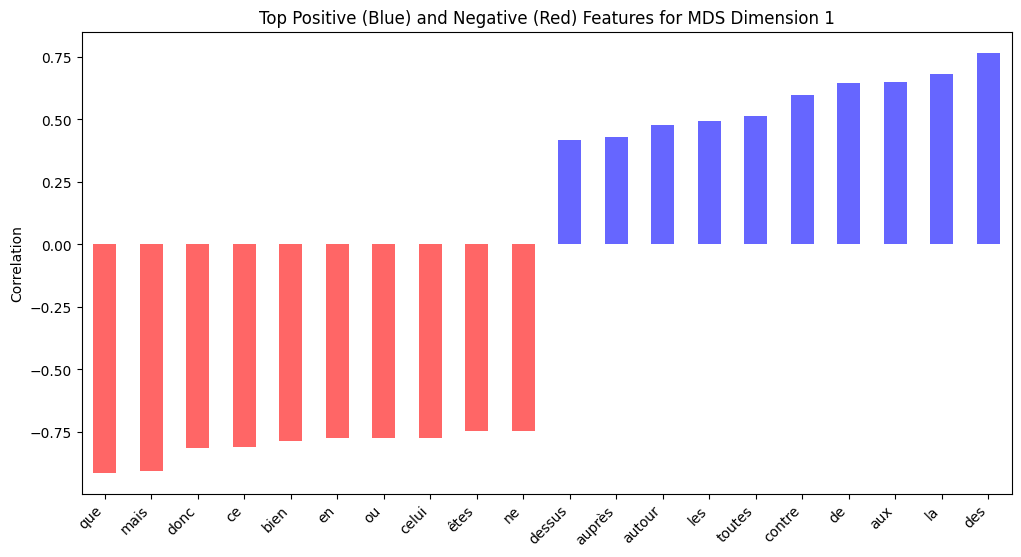

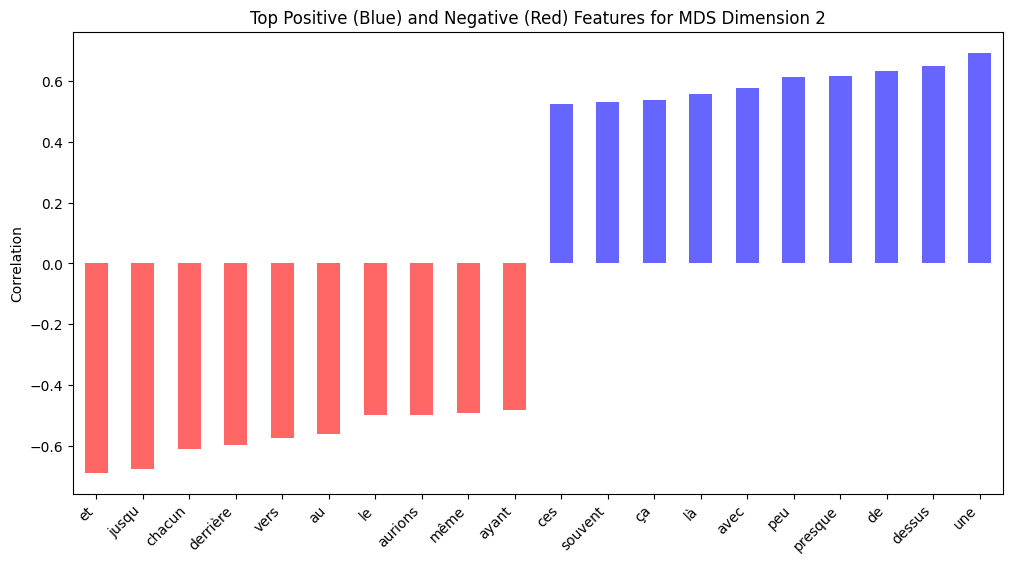

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Ensure dtm_matrix is a DataFrame with correct feature names
if not isinstance(dtm_matrix, pd.DataFrame):
    feature_names = vectorizer.get_feature_names_out()  # Replace 'vectorizer' with your actual vectorizer instance
    dtm_df = pd.DataFrame(dtm_matrix, columns=feature_names)
else:
    dtm_df = dtm_matrix  # It's already a DataFrame with columns

# Create a DataFrame from the MDS results
mds_df = pd.DataFrame(mds_result, columns=['MDS_1', 'MDS_2'])

# Concatenate the DTM features with the MDS results
merged_df = pd.concat([dtm_df, mds_df], axis=1)

# Compute correlation between DTM features and MDS components
correlation_matrix = merged_df.corr()

# Extract correlations of each feature with the MDS dimensions
mds_feature_correlation = correlation_matrix[['MDS_1', 'MDS_2']].drop(['MDS_1', 'MDS_2'])

def get_top_positive_negative(correlations, dimension):
    sorted_corr = correlations[dimension].sort_values()
    top_negative = sorted_corr.head(10)
    top_positive = sorted_corr.tail(10)
    return top_positive, top_negative

# Get top positive and negative features for MDS Dimension 1
top_positive_mds1, top_negative_mds1 = get_top_positive_negative(mds_feature_correlation, 'MDS_1')

# Get top positive and negative features for MDS Dimension 2
top_positive_mds2, top_negative_mds2 = get_top_positive_negative(mds_feature_correlation, 'MDS_2')

print("\nTop 10 positive features correlated with MDS Dimension 1:")
print(top_positive_mds1)
print("\nTop 10 negative features correlated with MDS Dimension 1:")
print(top_negative_mds1)
print("\nTop 10 positive features correlated with MDS Dimension 2:")
print(top_positive_mds2)
print("\nTop 10 negative features correlated with MDS Dimension 2:")
print(top_negative_mds2)

def plot_top_features(top_positive, top_negative, dimension):
    plt.figure(figsize=(12, 6))
    top_features = pd.concat([top_negative, top_positive])
    colors = ['red'] * len(top_negative) + ['blue'] * len(top_positive)
    top_features.plot(kind='bar', color=colors, alpha=0.6)
    plt.title(f"Top Positive (Blue) and Negative (Red) Features for {dimension}")
    plt.ylabel("Correlation")
    plt.xticks(rotation=45, ha='right')
    plt.show()

plot_top_features(top_positive_mds1, top_negative_mds1, 'MDS Dimension 1')
plot_top_features(top_positive_mds2, top_negative_mds2, 'MDS Dimension 2')


### Non metric MDS (Isomap)

Trustworthiness : 0.9166
Très bon ajustement (les relations de voisinage sont bien conservées).


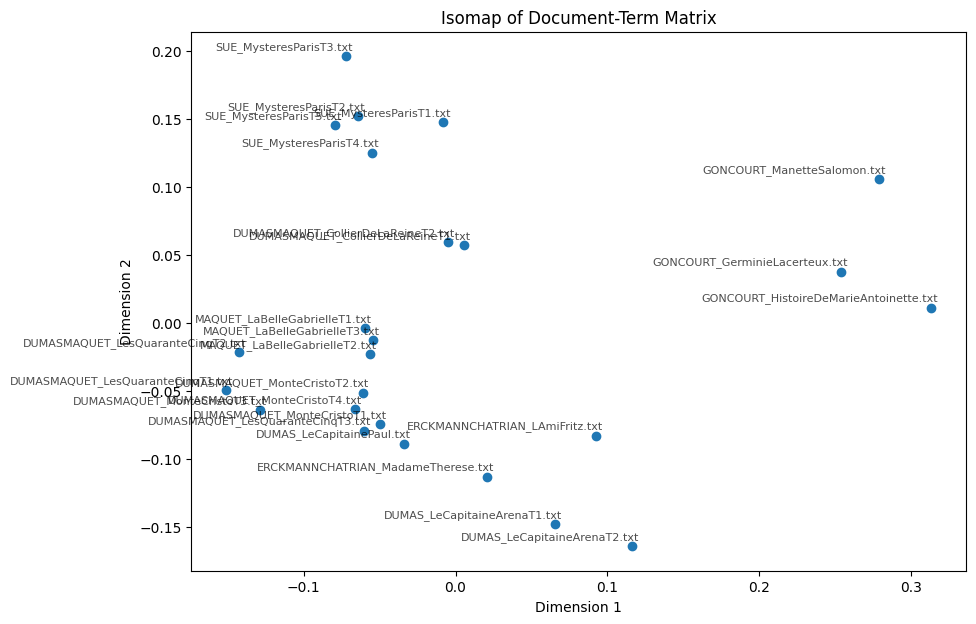

In [ ]:
# Définir le nombre de voisins à utiliser pour Isomap
n_neighbors = 6  # Ajustez ce nombre selon votre jeu de données

# Calculer Isomap avec le nombre de voisins spécifié
isomap = Isomap(n_neighbors=n_neighbors, n_components=2)
isomap_result = isomap.fit_transform(dtm_matrix)

# Calculer la métrique de confiance (trustworthiness)
trust_score = trustworthiness(dtm_matrix, isomap_result, n_neighbors=n_neighbors)

# Afficher le score de trustworthiness avec une interprétation
print(f"Trustworthiness : {trust_score:.4f}")
if trust_score > 0.9:
    print("Très bon ajustement (les relations de voisinage sont bien conservées).")
elif trust_score > 0.8:
    print("Bon ajustement (les relations de voisinage sont assez bien conservées).")
elif trust_score > 0.7:
    print("Ajustement moyen (certaines relations de voisinage sont perdues).")
else:
    print("Ajustement faible (les relations de voisinage ne sont pas bien conservées).")

# Visualiser le résultat d'Isomap
plt.figure(figsize=(10, 7))
plt.scatter(isomap_result[:, 0], isomap_result[:, 1])

plt.title("Isomap of Document-Term Matrix")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

# Ajouter les noms des fichiers comme labels pour chaque point
for i, filename in enumerate(filtered_file_names):
    plt.annotate(
        filename,
        (isomap_result[i, 0], isomap_result[i, 1]),
        textcoords="offset points",
        xytext=(5, 5),  # Décalage du label pour éviter le chevauchement
        ha="right",
        fontsize=8,
        alpha=0.7
    )

plt.show()


#### Coloring by labels

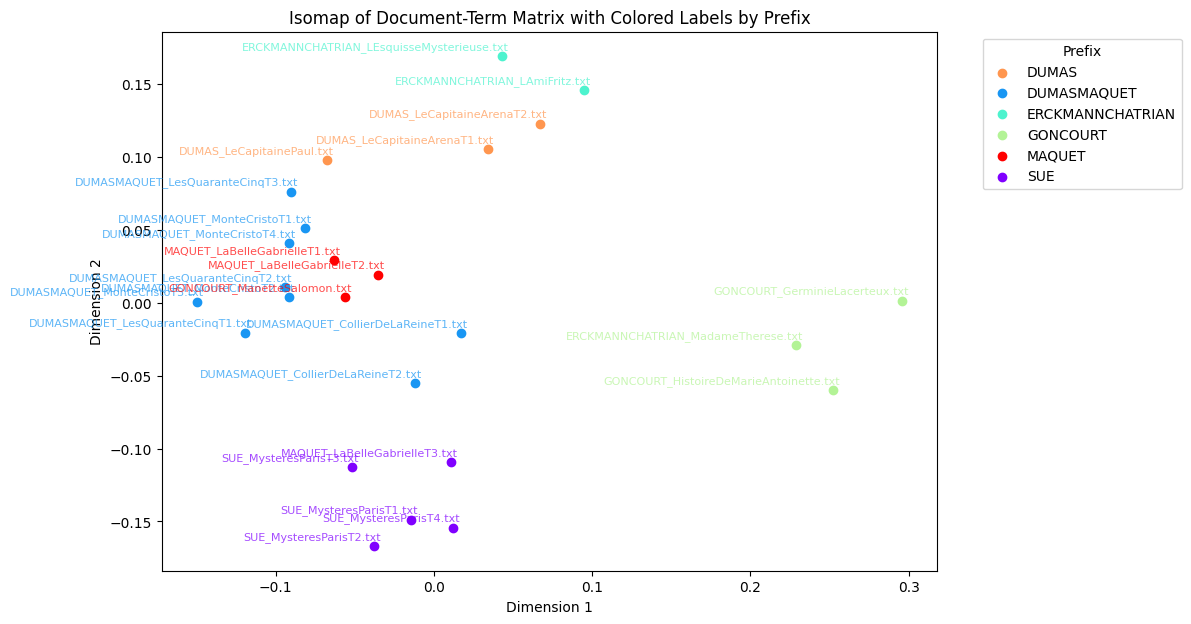

In [ ]:
# Extract prefixes from filenames, ensuring alignment with isomap_result
prefixes = [filename.split("_")[0] for filename in filtered_file_names]  # Use file_names instead of filtered_file_names

# Get unique prefixes and assign each a unique color
unique_prefixes = list(set(prefixes))
colors = cm.rainbow(np.linspace(0, 1, len(unique_prefixes)))  # Generate colors from a colormap
color_map = {prefix: color for prefix, color in zip(unique_prefixes, colors)}

# Plot Isomap result with colored labels based on prefix
plt.figure(figsize=(10, 7))
for i, (x, y) in enumerate(isomap_result):
    # Ensure i is within the bounds of prefixes
    if i < len(prefixes):
        prefix = prefixes[i]
        plt.scatter(x, y, color=color_map[prefix], label=prefix if i == prefixes.index(prefix) else "")  # Show label in legend once
        plt.annotate(
            file_names[i],  # Use file_names consistently
            (x, y),
            textcoords="offset points",
            xytext=(5, 5),  # Offset label to avoid overlap with the point
            ha="right",
            fontsize=8,     # Adjust font size for readability
            alpha=0.7,      # Slight transparency for better readability
            color=color_map[prefix]  # Color based on prefix
        )

# Add plot title and labels
plt.title("Isomap of Document-Term Matrix with Colored Labels by Prefix")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

# Create a legend to show which color corresponds to each prefix
plt.legend(title="Prefix", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

#### Interpretation of the Isomap


Top 10 positive features correlated with Isomap Dimension 1:
contre    0.449642
dessus    0.467544
dans      0.506688
autour    0.520228
les       0.532396
toutes    0.534681
de        0.565701
aux       0.588930
la        0.615463
des       0.808946
Name: Isomap_1, dtype: float64

Top 10 negative features correlated with Isomap Dimension 1:
mais   -0.933935
que    -0.915716
donc   -0.869720
ce     -0.844784
suis   -0.836093
bien   -0.814114
ai     -0.803129
ne     -0.799507
est    -0.799317
êtes   -0.799239
Name: Isomap_1, dtype: float64

Top 10 positive features correlated with Isomap Dimension 2:
certains    0.602844
presque     0.605560
auprès      0.668912
de          0.670340
ici         0.672910
toujours    0.689494
ça          0.691290
très        0.703073
pourtant    0.759236
souvent     0.763179
Name: Isomap_2, dtype: float64

Top 10 negative features correlated with Isomap Dimension 2:
chacun      -0.784505
et          -0.783202
avaient     -0.769929
vers        -0.754358
é

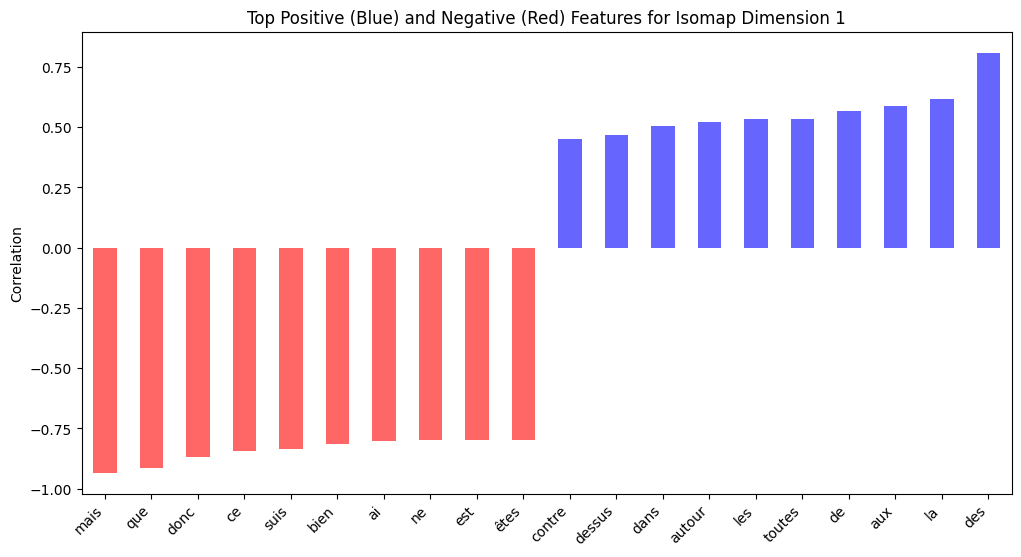

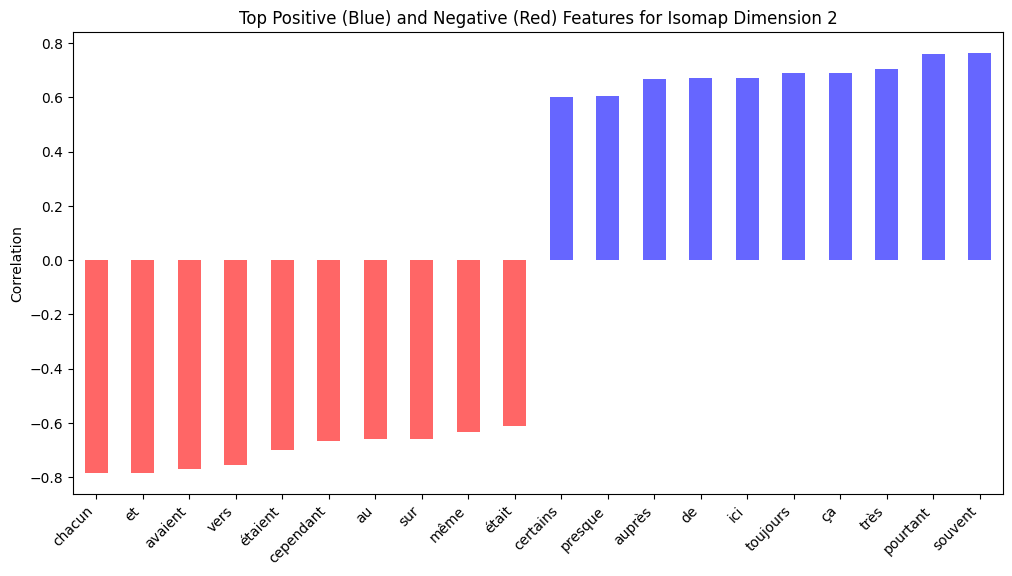

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Ensure dtm_matrix is a DataFrame with correct feature names
if not isinstance(dtm_matrix, pd.DataFrame):
    feature_names = vectorizer.get_feature_names_out()  # Replace 'vectorizer' with your actual vectorizer instance
    dtm_df = pd.DataFrame(dtm_matrix, columns=feature_names)
else:
    dtm_df = dtm_matrix  # It's already a DataFrame with columns

# Create a DataFrame from the Isomap results
isomap_df = pd.DataFrame(isomap_result, columns=['Isomap_1', 'Isomap_2'])

# Concatenate the DTM features with the Isomap results
merged_df = pd.concat([dtm_df, isomap_df], axis=1)

# Compute correlation between DTM features and Isomap components
correlation_matrix = merged_df.corr()

# Extract correlations of each feature with the Isomap dimensions
isomap_feature_correlation = correlation_matrix[['Isomap_1', 'Isomap_2']].drop(['Isomap_1', 'Isomap_2'])

# Function to get top 10 positive and top 10 negative features for each dimension
def get_top_positive_negative(correlations, dimension):
    # Sort correlations for the specified dimension
    sorted_corr = correlations[dimension].sort_values()
    # Get top 10 negative and top 10 positive correlations
    top_negative = sorted_corr.head(10)
    top_positive = sorted_corr.tail(10)
    return top_positive, top_negative

# Get top positive and negative features for Isomap Dimension 1
top_positive_isomap1, top_negative_isomap1 = get_top_positive_negative(isomap_feature_correlation, 'Isomap_1')

# Get top positive and negative features for Isomap Dimension 2
top_positive_isomap2, top_negative_isomap2 = get_top_positive_negative(isomap_feature_correlation, 'Isomap_2')

# Print results
print("\nTop 10 positive features correlated with Isomap Dimension 1:")
print(top_positive_isomap1)

print("\nTop 10 negative features correlated with Isomap Dimension 1:")
print(top_negative_isomap1)

print("\nTop 10 positive features correlated with Isomap Dimension 2:")
print(top_positive_isomap2)

print("\nTop 10 negative features correlated with Isomap Dimension 2:")
print(top_negative_isomap2)

# Plot the top positive and negative correlated features
def plot_top_features(top_positive, top_negative, dimension):
    plt.figure(figsize=(12, 6))
    top_features = pd.concat([top_negative, top_positive])
    colors = ['red'] * len(top_negative) + ['blue'] * len(top_positive)
    top_features.plot(kind='bar', color=colors, alpha=0.6)
    plt.title(f"Top Positive (Blue) and Negative (Red) Features for {dimension}")
    plt.ylabel("Correlation")
    plt.xticks(rotation=45, ha='right')
    plt.show()

# Plot for Isomap Dimension 1
plot_top_features(top_positive_isomap1, top_negative_isomap1, 'Isomap Dimension 1')

# Plot for Isomap Dimension 2
plot_top_features(top_positive_isomap2, top_negative_isomap2, 'Isomap Dimension 2')


# Clustering

## Hierarchical clustering

### Euclidean distance (just for fun)

Number of documents: 25
Number of labels: 25
Dunn Index: 0.5136


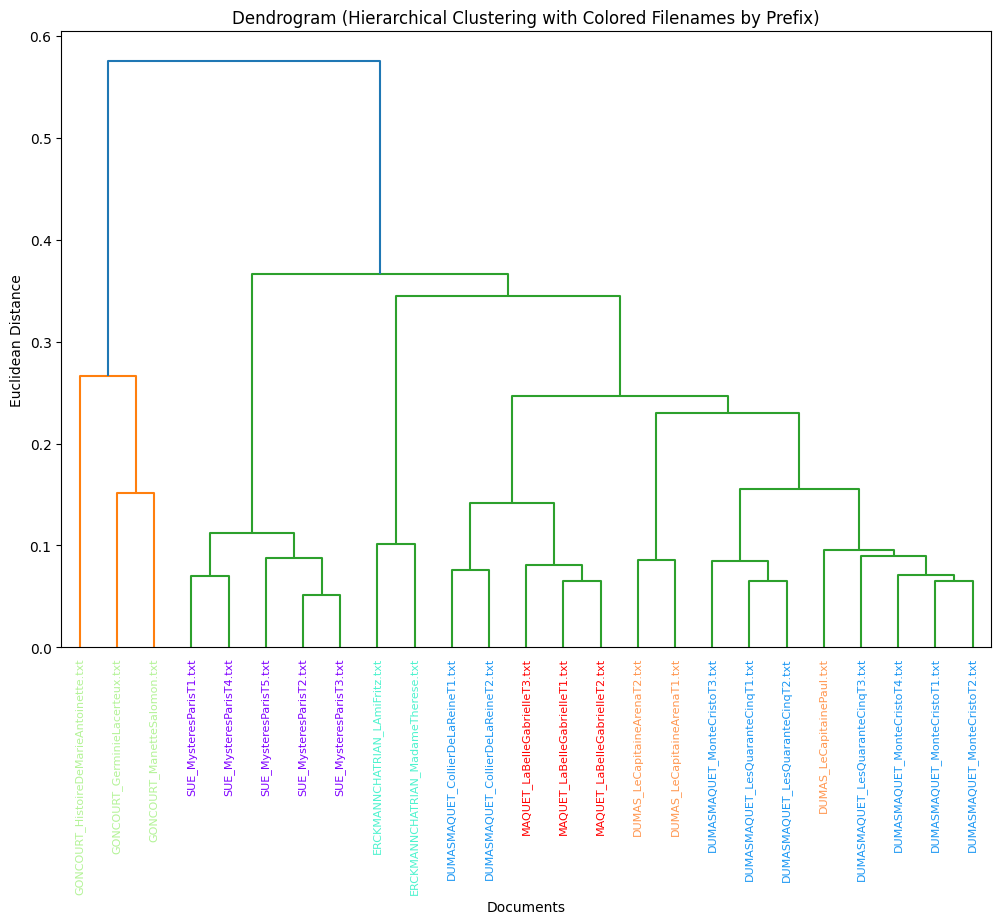

In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Étape 1 : Calculer la matrice de distance et effectuer le clustering hiérarchique
distance_matrix = pdist(dtm_matrix, 'euclidean')  # Assurez-vous que dtm_matrix est sous forme de tableau
linkage_matrix = linkage(distance_matrix, 'ward')

# Vérification de l'alignement
num_documents = dtm_matrix.shape[0]
num_labels = len(filtered_file_names)
print(f"Number of documents: {num_documents}")
print(f"Number of labels: {num_labels}")

if num_documents != num_labels:
    print("Mismatch between the number of documents and labels.")
    raise ValueError("The number of documents and labels do not match.")

# Extraire les préfixes des noms de fichiers
prefixes = [filename.split("_")[0] for filename in filtered_file_names]
unique_prefixes = list(set(prefixes))
colors = cm.rainbow(np.linspace(0, 1, len(unique_prefixes)))
color_map = {prefix: color for prefix, color in zip(unique_prefixes, colors)}

# Étape 2 : Créer les clusters
# Choisissez un seuil pour couper l'arbre hiérarchique et former des clusters
num_clusters = 5  # Ajustez ce nombre en fonction de vos besoins
clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Étape 3 : Calculer l'index de Dunn
def calculate_dunn_index(distance_matrix, clusters):
    """
    Calcule l'index de Dunn pour une classification donnée.
    """
    # Convertir la matrice de distances en matrice carrée
    dist_matrix_square = squareform(distance_matrix)

    # Calculer le diamètre maximal (intra-cluster)
    max_intra_distances = []
    for cluster in np.unique(clusters):
        indices = np.where(clusters == cluster)[0]
        if len(indices) > 1:
            intra_distances = dist_matrix_square[np.ix_(indices, indices)]
            max_intra_distances.append(np.max(intra_distances))
        else:
            max_intra_distances.append(0)  # Cas où le cluster a un seul élément
    max_diameter = max(max_intra_distances)

    # Calculer la distance minimale (inter-cluster)
    min_inter_distance = float('inf')
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            if clusters[i] != clusters[j]:
                min_inter_distance = min(min_inter_distance, dist_matrix_square[i, j])

    # Calculer l'index de Dunn
    dunn_index = min_inter_distance / max_diameter if max_diameter > 0 else 0
    return dunn_index

# Calculer et afficher l'index de Dunn
dunn_index = calculate_dunn_index(distance_matrix, clusters)
print(f"Dunn Index: {dunn_index:.4f}")

# Étape 4 : Visualiser le dendrogramme
plt.figure(figsize=(12, 8))
dendro = dendrogram(
    linkage_matrix,
    labels=filtered_file_names,
    leaf_rotation=90,
    leaf_font_size=8,
)
plt.title("Dendrogram (Hierarchical Clustering with Colored Filenames by Prefix)")
plt.xlabel("Documents")
plt.ylabel("Euclidean Distance")

# Appliquer des couleurs aux étiquettes en fonction du préfixe
ax = plt.gca()
x_labels = ax.get_xmajorticklabels()
for label in x_labels:
    filename = label.get_text()
    prefix = filename.split("_")[0]
    label.set_color(color_map[prefix])

plt.show()


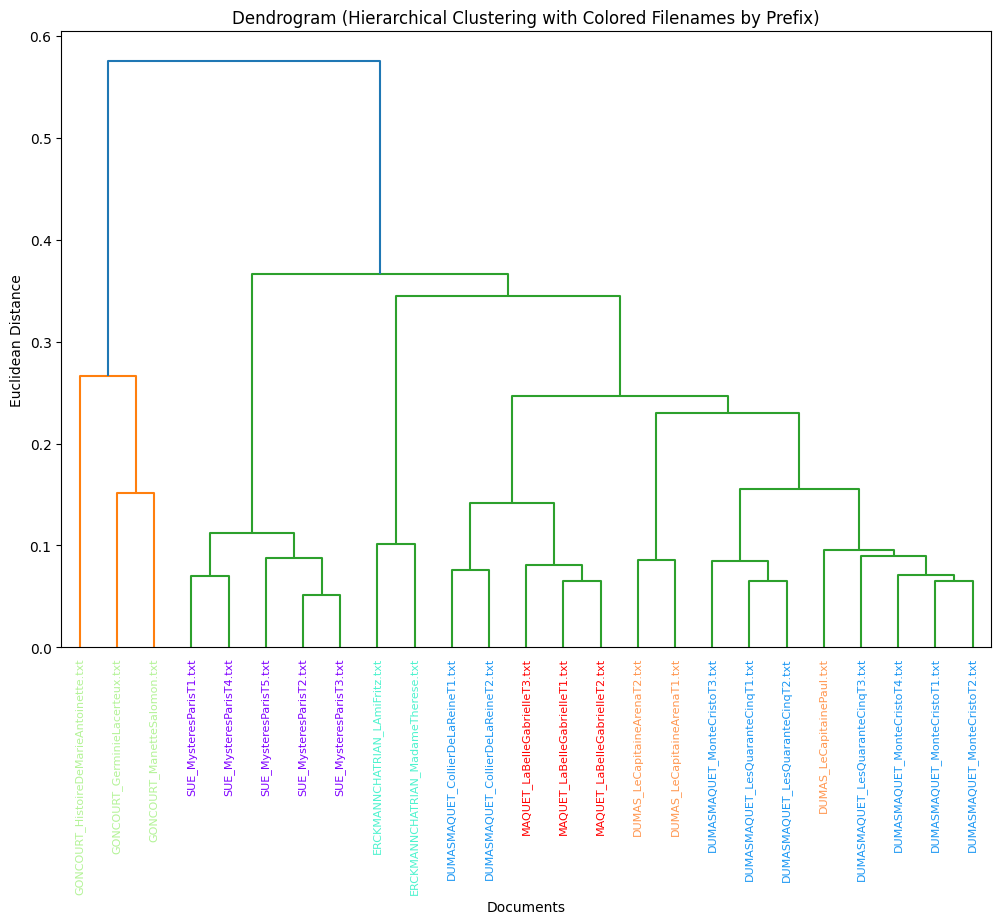

In [ ]:
# Using Euclidean distance and Ward's method for hierarchical clustering
distance_matrix = pdist(dtm_matrix, 'euclidean')
linkage_matrix = linkage(distance_matrix, 'ward')




# Extract prefixes from filenames
prefixes = [filename.split("_")[0] for filename in filtered_file_names]

# Get unique prefixes and assign each a unique color
unique_prefixes = list(set(prefixes))
colors = cm.rainbow(np.linspace(0, 1, len(unique_prefixes)))  # Generate colors from a colormap
color_map = {prefix: color for prefix, color in zip(unique_prefixes, colors)}

# Plot the Dendrogram with filenames as labels
plt.figure(figsize=(12, 8))
dendro = dendrogram(
    linkage_matrix,
    labels=filtered_file_names,    # Use filenames as labels
    leaf_rotation=90,     # Rotate labels for readability
    leaf_font_size=8,     # Adjust font size for readability
)
plt.title("Dendrogram (Hierarchical Clustering with Colored Filenames by Prefix)")
plt.xlabel("Documents")
plt.ylabel("Euclidean Distance")

# Apply colors to the labels based on the prefix
ax = plt.gca()
x_labels = ax.get_xmajorticklabels()
for label in x_labels:
    filename = label.get_text()
    prefix = filename.split("_")[0]  # Get the prefix
    label.set_color(color_map[prefix])  # Set color based on prefix

plt.show()


### With cosine distance

Dunn Index: 0.2638


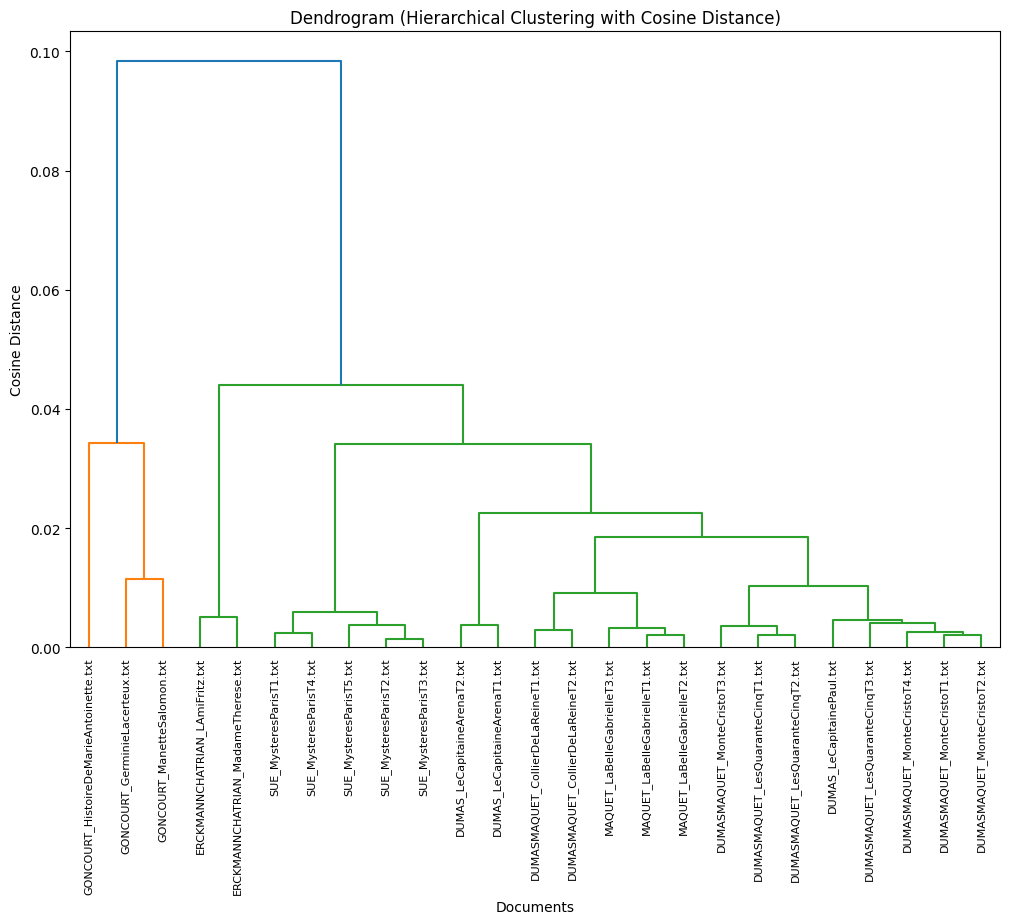

In [ ]:
# Using Cosine distance and Ward's method for hierarchical clustering
# Compute cosine distance matrix
distance_matrix = pdist(dtm_matrix, 'cosine')
linkage_matrix = linkage(distance_matrix, 'ward')

# Create clusters using a specified number of clusters
num_clusters = 5  # Adjust this value based on your dataset
clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Calculate and display the Dunn Index
dunn_index = calculate_dunn_index(distance_matrix, clusters)
print(f"Dunn Index: {dunn_index:.4f}")

# Plot the Dendrogram with filenames as labels
plt.figure(figsize=(12, 8))
dendrogram(
    linkage_matrix,
    labels=filtered_file_names,    # Use filenames as labels
    leaf_rotation=90,     # Rotate labels for readability
    leaf_font_size=8,     # Adjust font size for readability
)
plt.title("Dendrogram (Hierarchical Clustering with Cosine Distance)")
plt.xlabel("Documents")
plt.ylabel("Cosine Distance")
plt.show()


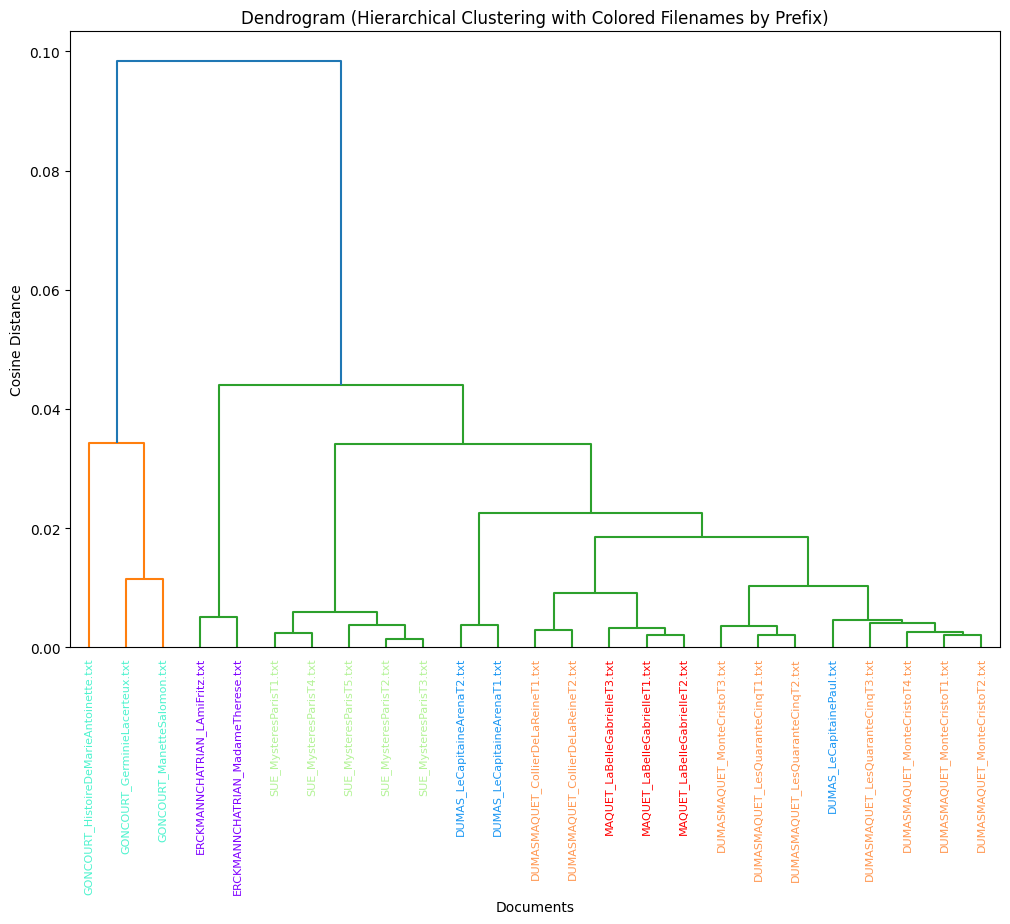

In [ ]:
# Using Cosine distance and Ward's method for hierarchical clustering
# Compute cosine distance matrix
distance_matrix = pdist(dtm_matrix, 'cosine')
linkage_matrix = linkage(distance_matrix, 'ward')

# Extract prefixes from filenames
prefixes = [filename.split("_")[0] for filename in filtered_file_names]

# Get unique prefixes and assign each a unique color
unique_prefixes = list(set(prefixes))
colors = cm.rainbow(np.linspace(0, 1, len(unique_prefixes)))  # Generate colors from a colormap
color_map = {prefix: color for prefix, color in zip(unique_prefixes, colors)}

# Plot the Dendrogram with filenames as labels
plt.figure(figsize=(12, 8))
dendro = dendrogram(
    linkage_matrix,
    labels=filtered_file_names,    # Use filenames as labels
    leaf_rotation=90,     # Rotate labels for readability
    leaf_font_size=8,     # Adjust font size for readability
)
plt.title("Dendrogram (Hierarchical Clustering with Colored Filenames by Prefix)")
plt.xlabel("Documents")
plt.ylabel("Cosine Distance")

# Apply colors to the labels based on the prefix
ax = plt.gca()
x_labels = ax.get_xmajorticklabels()
for label in x_labels:
    filename = label.get_text()
    prefix = filename.split("_")[0]  # Get the prefix
    label.set_color(color_map[prefix])  # Set color based on prefix

plt.show()


It is sometimes recommanded to move away from Ward's method when using non-Euclidean distance measure. Ward's method indeed assumes a euclidean world.We could then set it to "average" for instance. Average linkage, unlike Ward’s method, does not assume or require Euclidean properties in the data. It doesn’t rely on assumptions about variance, so it adapts better to distances that reflect similarity or angular relationships rather than strict spatial positions.

Dunn Index: 0.2002


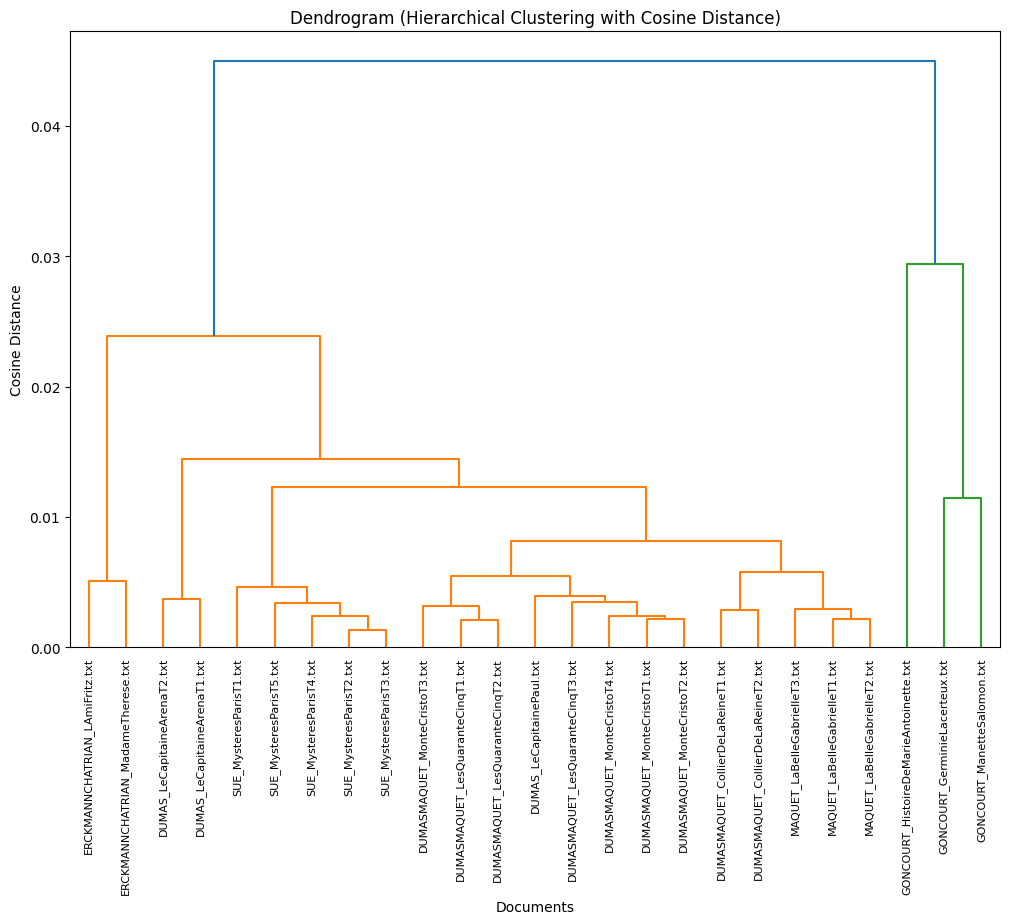

In [ ]:
# Using Cosine distance and Ward's method for hierarchical clustering
# Compute cosine distance matrix
distance_matrix = pdist(dtm_matrix, 'cosine')
linkage_matrix = linkage(distance_matrix, 'average')

# Create clusters using a specified number of clusters
num_clusters = 5  # Adjust this value based on your dataset
clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Calculate and display the Dunn Index
dunn_index = calculate_dunn_index(distance_matrix, clusters)
print(f"Dunn Index: {dunn_index:.4f}")


# Plot the Dendrogram with filenames as labels
plt.figure(figsize=(12, 8))
dendrogram(
    linkage_matrix,
    labels=filtered_file_names,    # Use filenames as labels
    leaf_rotation=90,     # Rotate labels for readability
    leaf_font_size=8,     # Adjust font size for readability
)
plt.title("Dendrogram (Hierarchical Clustering with Cosine Distance)")
plt.xlabel("Documents")
plt.ylabel("Cosine Distance")
plt.show()



With label coloring

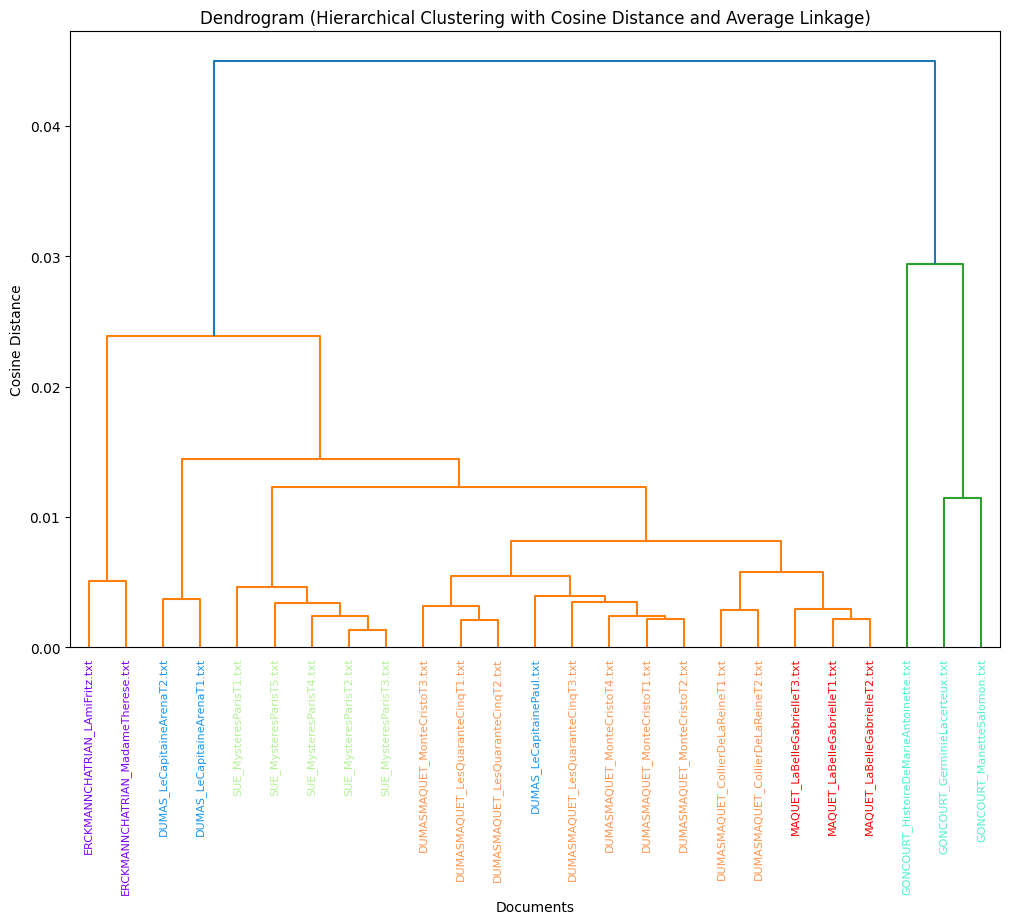

In [ ]:
# Using Cosine distance and Average linkage for hierarchical clustering
# Compute cosine distance matrix
distance_matrix = pdist(dtm_matrix, 'cosine')
linkage_matrix = linkage(distance_matrix, 'average')

# Extract prefixes from filenames
prefixes = [filename.split("_")[0] for filename in filtered_file_names]

# Get unique prefixes and assign each a unique color
unique_prefixes = list(set(prefixes))
colors = cm.rainbow(np.linspace(0, 1, len(unique_prefixes)))  # Generate colors from a colormap
color_map = {prefix: color for prefix, color in zip(unique_prefixes, colors)}

# Plot the Dendrogram with filenames as labels
plt.figure(figsize=(12, 8))
dendro = dendrogram(
    linkage_matrix,
    labels=filtered_file_names,    # Use filenames as labels
    leaf_rotation=90,     # Rotate labels for readability
    leaf_font_size=8,     # Adjust font size for readability
)
plt.title("Dendrogram (Hierarchical Clustering with Cosine Distance and Average Linkage)")
plt.xlabel("Documents")
plt.ylabel("Cosine Distance")

# Apply colors to the labels based on the prefix
ax = plt.gca()
x_labels = ax.get_xmajorticklabels()
for label in x_labels:
    filename = label.get_text()
    prefix = filename.split("_")[0]  # Get the prefix
    label.set_color(color_map[prefix])  # Set color based on prefix

plt.show()



## K-means

Cluster Labels: [2 2 0 4 4 0 0 0 0 0 0 0 2 2 1 1 1 4 4 4 4 3 3 3 3]
Silhouette Score for K-Means clustering: 0.23543835600538404


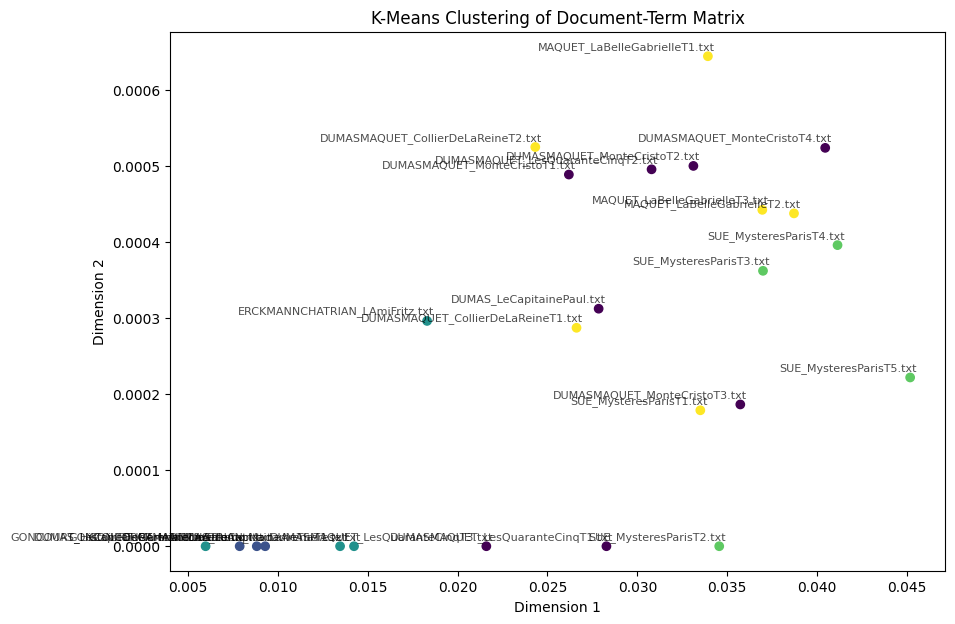

In [ ]:
# K-Means Clustering as an alternative to Hierarchical Clustering
kmeans = KMeans(n_clusters=5, random_state=42) #set the number of clusters appropriately, depending on the number of expected authors (when known)
kmeans_labels = kmeans.fit_predict(dtm_matrix)
print("Cluster Labels:", kmeans_labels)

# Silhouette Score to assess clustering performance
silhouette_avg = silhouette_score(dtm_matrix, kmeans_labels)
print("Silhouette Score for K-Means clustering:", silhouette_avg)

# Plot the K-Means Clustering result with labels
plt.figure(figsize=(10, 7))
plt.scatter(dtm_matrix[:, 0], dtm_matrix[:, 1], c=kmeans_labels, cmap='viridis')

# Add file names as labels for each point
for i, filename in enumerate(filtered_file_names):
    plt.annotate(
        filename,
        (dtm_matrix[i, 0], dtm_matrix[i, 1]),
        textcoords="offset points",
        xytext=(5, 5),  # Offset label to avoid overlap with the point
        ha="right",
        fontsize=8,     # Adjust font size for readability
        alpha=0.7       # Slight transparency for better readability
    )

plt.title("K-Means Clustering of Document-Term Matrix")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


## Heatmap

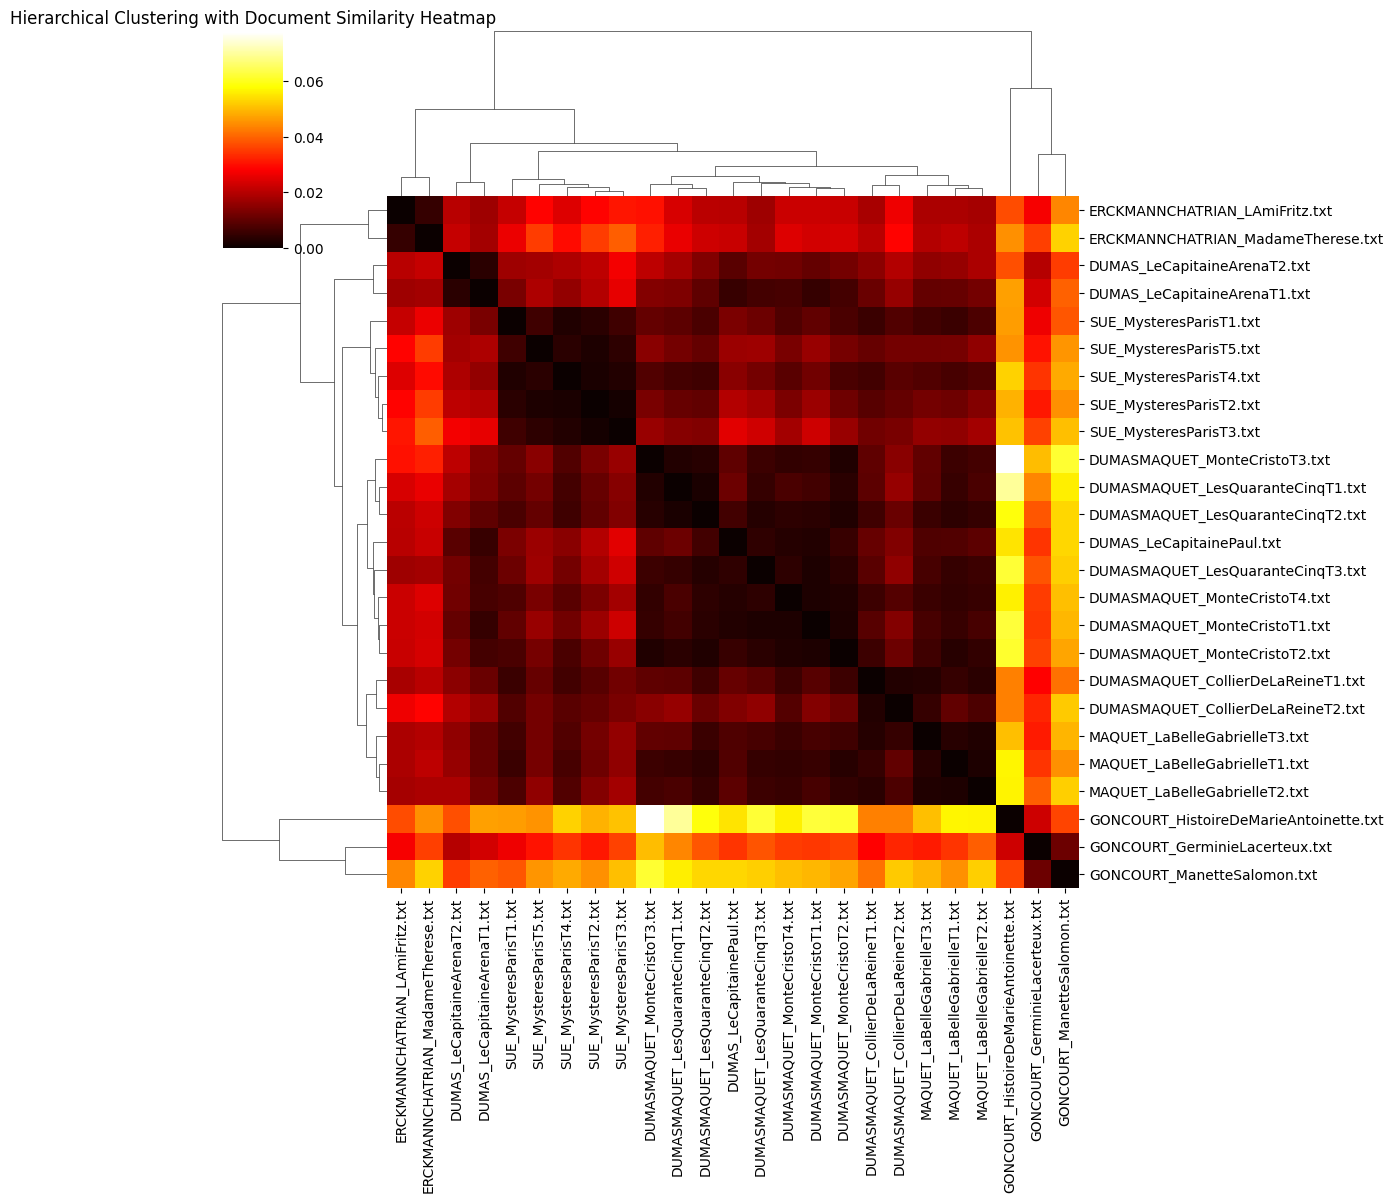

In [ ]:
# Compute cosine distance matrix
distance_matrix = pdist(dtm_matrix, 'cosine')
distance_squareform = squareform(distance_matrix)

# Extract prefixes from filenames
prefixes = [filename.split("_")[0] for filename in filtered_file_names]

# Assign unique colors to each prefix
unique_prefixes = list(set(prefixes))
colors = cm.rainbow(np.linspace(0, 1, len(unique_prefixes)))  # Generate colors from a colormap
color_map = {prefix: color for prefix, color in zip(unique_prefixes, colors)}
row_colors = [color_map[prefix] for prefix in prefixes]  # Map colors to each document based on prefix

# Perform hierarchical clustering
linkage_matrix = linkage(distance_matrix, method='average')  # You can choose other methods (e.g., 'ward', 'complete')

# Create a DataFrame for `seaborn.clustermap`
distance_df = pd.DataFrame(distance_squareform, index=filtered_file_names, columns=filtered_file_names)

# Plot clustermap with hierarchical clustering and colored labels
sns.clustermap(
    distance_df,
    cmap="hot",                        # Heatmap color map
    row_linkage=linkage_matrix,        # Use the linkage matrix for clustering rows
    col_linkage=linkage_matrix,        # Use the same linkage matrix for columns (symmetric matrix)
    figsize=(12, 12),                  # Adjust size as needed
    xticklabels=filtered_file_names,   # Show filenames on x-axis
    yticklabels=filtered_file_names    # Show filenames on y-axis
)

plt.title("Hierarchical Clustering with Document Similarity Heatmap")
plt.show()


## Mann-Whitney

In [ ]:
## Mann-Whitney test example
# An example of a Mann-Whitney test comparing two sample document groups
# Select two document groups for the test (adjust indices as needed)
group1 = dtm_matrix[:5].sum(axis=0)
group2 = dtm_matrix[5:10].sum(axis=0)
stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
print("Mann-Whitney test result: statistic =", stat, ", p-value =", p_value)